# Transaction cost optimization for online portfolio selection
## Bin Li, Jialei Wang, Dingjiang Huang & Steven C. H. Hoi


In [1]:
from scipy.io import loadmat
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix, solvers
from tqdm import tqdm
data = loadmat(r"C:\Users\kelvi\Downloads\nyse-o.mat")


In [2]:
arr = data['data']
df = pd.DataFrame(arr)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
0,1.01515,1.02765,1.04183,1.02083,1.00637,1.04938,1.00847,1.01983,1.05426,0.99751,...,1.03148,1.03377,1.01018,1.01495,1.00775,1.00526,1.01176,1.00578,0.99697,0.99752
1,1.01493,1.04036,0.98905,0.99490,1.00475,0.95294,1.00840,1.00833,1.04412,1.00500,...,1.00898,1.00251,1.01259,1.00000,1.00192,1.00000,1.01938,1.00958,0.99088,1.00248
2,1.00000,0.97629,0.97786,0.99744,0.98583,0.98765,0.99722,0.99449,0.97183,1.00000,...,0.98043,0.95990,0.99751,0.97218,0.98656,0.98429,0.97338,1.00000,1.02761,0.99752
3,1.02451,1.00662,1.02642,1.00257,1.01917,1.00000,0.99443,1.00693,1.00000,1.00000,...,1.01089,1.03655,1.01247,0.99663,1.00778,1.01596,1.00000,1.00190,1.00299,1.02233
4,1.03100,0.98465,1.00368,1.00513,1.00313,1.05000,1.02801,1.00413,1.05797,1.01741,...,1.01077,0.99496,0.99507,0.98649,1.01158,0.99738,1.01563,1.01515,1.01190,1.00971


In [4]:

def project_to_simplex(u):
    """
    Euclidean projection of u onto { b >= 0, sum(b) = 1 }.
    """
    u_sorted = np.sort(u)[::-1]
    cssv = np.cumsum(u_sorted)
    rho = -1
    for j in range(len(u)):
        t = (cssv[j] - 1.0) / (j + 1)
        if u_sorted[j] - t > 0:
            rho = j
    theta = (cssv[rho] - 1.0) / (rho + 1)
    return np.maximum(u - theta, 0.0)



def compute_bcrp(arr, step_size=0.01, max_iters=1000, tol=1e-8):

    T, N = arr.shape
    b = np.ones(N) / N           
    prev_obj = -np.inf

    for it in range(max_iters):
        b_dot = arr.dot(b)
        b_dot = np.maximum(b_dot, 1e-16)
        
        obj = np.sum(np.log(b_dot))
        if it > 0 and abs(obj - prev_obj) < tol:
            break
        prev_obj = obj
        
        grad_matrix = arr / b_dot[:, np.newaxis]   
        grad = np.sum(grad_matrix, axis=0)         
        
        b_mid = b + step_size * grad
        b = project_to_simplex(b_mid)
    
    return b

def firststratbench(arr):
    T, N = arr.shape

    cumprod = np.cumprod(arr, axis=0) 

    gamma_values = [0.0, 0.0025, 0.005] 

    results = {
        "BAH":    {},
        "Best":   {},
        "BCRP":   {}
    }

    b_star = compute_bcrp(arr, step_size=0.01, max_iters=1000, tol=1e-9)


    for gamma in gamma_values:
        label = f"{gamma*100:.2f}%"  

        #BAH: equally‐weighted, pay one‐way fee at t=0 only --
        W0 = 1.0 - gamma
        wealth_curve_bah = W0 * cumprod.mean(axis=1)
        results["BAH"][label] = wealth_curve_bah[-1]

        #BestStock: put all capital in the single best‐return ticker in hindsight,
        terminal_returns = cumprod[-1, :]         
        results["Best"][label] = (1.0 - gamma) * terminal_returns.max()

        #BCRP with proportional transaction costs each day --
        W = 1.0 - gamma
        for t in range(T):
            x_t = arr[t]  
            gross = W * (b_star.dot(x_t))
            hat_b = (b_star * x_t) / (b_star.dot(x_t))
            cost_frac = gamma * np.linalg.norm(hat_b - b_star, ord=1)
            W = gross * (1.0 - cost_frac)
        results["BCRP"][label] = W


    df = pd.DataFrame(results).T.round(2)
    return df
df = firststratbench(arr)
print(df)


       0.00%   0.25%   0.50%
BAH    14.50   14.46   14.42
Best   54.14   54.01   53.87
BCRP  250.60  181.99  132.16


## Universal Portfolio (Cover, 1991)

The Universal Portfolio (UP) is an **online portfolio-selection algorithm** that, at each time step, invests according to a weighted average of **all** constant-rebalanced portfolios (CRPs), where each CRP’s weight is proportional to its historical performance. Over time, UP “learns” to track the Single Best CRP in hindsight, achieving asymptotically the same growth rate. 


### 1. Background: Constant-Rebalanced Portfolios (CRPs)

A **Constant-Rebalanced Portfolio (CRP)** with weights  
$$
b = (b_1, \dots, b_N) \in \Delta^N
$$  
(the $N$-asset simplex) invests a fixed fraction $b_i$ of wealth in asset $i$ at the start of each period, then rebalances back to $b$ at the end of the period. Formally:

1.  Let 
    $$
      x_t = (x_{t,1}, \dots, x_{t,N}) 
      \quad\text{where}\quad 
      x_{t,i} = \frac{p_{t,i}}{p_{t-1,i}}
      \quad\text{(price-relative of asset $i$ at time $t$).}
    $$
2.  If at the start of period $t$ you hold portfolio $b$, your **pre-trade** wealth multiplies by 
    $$
      b^\top x_t \;=\; \sum_{i=1}^N b_i\,x_{t,i}.
    $$
3.  Immediately after observing $x_t$, you **rebalance**—i.e.\ sell or buy so that at the start of period $t+1$, you again hold exactly $b$. In a frictionless world, rebalancing costs nothing, so your wealth evolves simply as
    $$
      S_t(b) 
      \;=\; S_{t-1}(b)\,\bigl(b^\top x_t\bigr), 
      \quad S_0(b) = 1.
    $$
4.  Over $T$ periods, the final wealth of CRP $b$ is
    $$
      S_T(b) 
      \;=\; \prod_{t=1}^T \bigl(b^\top x_t\bigr).
    $$
5.  The **Best CRP in hindsight** is 
    $$
      b^* \;=\; \underset{b\in\Delta^N}{\arg\max}\;S_T(b)
      \;=\;\underset{b\in\Delta^N}{\arg\max}\;\sum_{t=1}^T \log\bigl(b^\top x_t\bigr).
    $$
   However, $b^*$ cannot be computed online because it requires knowledge of all future price relatives $\{x_1, \dots, x_T\}$.

---

### 2. Universal Portfolio: Mixing Over All CRPs

Instead of selecting one fixed $b$ ex ante, the Universal Portfolio maintains a **continuous mixture** over all $b \in \Delta^N$, re-weighted in proportion to each $b$’s cumulative return so far.

1.  **Prior distribution** on $\Delta^N$.  
    Cover chooses a uniform prior $\pi_0(b)$ over the simplex. Equivalently, one can view this as Dirichlet $(1,\dots,1)$.

2.  **Wealth of each CRP** $b$ up to time $t$ (hindsight wealth):
    $$
      W_t(b) 
      \;=\; \prod_{s=1}^t \bigl(b^\top x_s\bigr).
    $$
   If $\pi_0(b)$ is uniform, the unnormalized posterior weight at time $t$ is
    $$
      w_t(b) 
      \;=\; \pi_0(b)\,W_t(b) 
      \;=\; W_t(b).
    $$
   The normalized posterior density is 
    $$
      \pi_t(b)
      \;=\;
      \frac{W_t(b)}{\displaystyle \int_{\Delta^N} W_t(u)\,du} 
      \;=\;
      \frac{\displaystyle\prod_{s=1}^t (b^\top x_s)}{\displaystyle\int_{\Delta^N} \prod_{s=1}^t (u^\top x_s)\,du}.
    $$

3.  **Mixture portfolio** at time $t+1$:
    $$
      B_{t+1}
      \;=\; 
      \int_{\Delta^N} b\,\pi_t(b)\,db 
      \;=\; 
      \frac{\displaystyle\int_{\Delta^N} b\,\prod_{s=1}^t (b^\top x_s)\,db}
           {\displaystyle\int_{\Delta^N} \prod_{s=1}^t (u^\top x_s)\,du}.
    $$
   In practice we approximate this continuous integral by Monte Carlo sampling.

4.  **Wealth recursion** of the Universal Portfolio:
    $$
      V_0 = 1, 
      \quad
      V_t = V_{t-1} \times \bigl(B_t^\top x_t\bigr).
    $$
   At the start of each day $t$, we hold $B_t$. After the market moves by $x_t$, wealth becomes $V_{t-1}\,(B_t^\top x_t)$. Then we rebalance to $B_{t+1}$ (zero-cost) before day $t+1$.

---

### 3. Step-by-Step Monte Carlo Approximation

Because the integrals over $\Delta^N$ are intractable, UP is implemented approximately by drawing $K$ i.i.d. samples $\{b^{(1)},\dots,b^{(K)}\}$ from Dirichlet $(1,\dots,1)$. Denote each sample’s wealth $W_t^{(k)}$. Then:

1.  **Initialization:**  
    $$
      W_0^{(k)} = 1, 
      \quad k = 1,\dots,K.
    $$

2.  **For each day $t = 1,2,\dots,T$:**  
    1.  **Compute each sample’s daily multiplier:**  
        $$
          \rho_t^{(k)} = b^{(k)\,\top} x_t,
          \quad k = 1,\dots,K.
        $$
    2.  **Update sample wealth:**  
        $$
          W_t^{(k)} = W_{t-1}^{(k)} \times \rho_t^{(k)}.
        $$
    3.  **Compute mixture weights (posterior probabilities):**  
        $$
          \hat\pi_t\bigl(b^{(k)}\bigr) 
          = \frac{W_t^{(k)}}{\sum_{\ell=1}^K W_t^{(\ell)}}.
        $$
    4.  **Form actual allocation:**  
        $$
          B_{t+1} 
          = \sum_{k=1}^K \hat\pi_t\bigl(b^{(k)}\bigr)\;b^{(k)},
        $$
        and rebalance your real capital to $B_{t+1}$.  
    5.  **Update real wealth:**  
        $$
          V_t = V_{t-1} \times \bigl(B_t^\top x_t\bigr),
          \quad V_0 = 1.
        $$
        (In a zero-cost environment, rebalancing to $B_{t+1}$ does not reduce wealth. If transaction costs $\gamma$ apply, subtract $\gamma \|\hat B_t - B_{t+1}\|_1$ of $V_{t-1}\,(B_t^\top x_t)$ before compounding.)

---

### 4. Pros and Cons of the Universal Portfolio

#### Pros

1.  **Asymptotic No-Regret:**  
    $$
      \lim_{T\to\infty} \frac{1}{T}\Bigl[\log V_T^{\text{UP}} - \log S_T(b^*)\Bigr] = 0.
    $$
   UP’s average log-growth rate converges to that of the hindsight-optimal CRP $b^*$, for *any* sequence $\{x_t\}$. No statistical assumptions are needed.

2.  **Completely Model-Free:**  
    No tuning parameters (aside from Monte Carlo sample size $K$). It adapts automatically to arbitrary market patterns.

3.  **Robustness:**  
    Unlike methods that rely on forecasting or specific return-models, UP makes no stationarity or i.i.d.\ assumptions. It is truly “universal” in the sense of guaranteeing performance relative to the best fixed portfolio.

4.  **Natural Bayesian Interpretation:**  
    UP is equivalent to a Bayesian “mixture of experts” strategy, where each CRP $b$ is treated as an “expert” whose likelihood is proportional to its realized wealth.

#### Cons

1.  **Computational Cost:**  
    - Exact UP requires evaluating high-dimensional integrals over $\Delta^N$ at each $t$, which is infeasible when $N>2$.  
    - Monte Carlo UP demands $O(KN)$ per day (to update $W_t^{(k)}$ for $k=1,\dots,K$ and compute a weighted average of $K$ vectors). If $N$ or $K$ is large, this becomes expensive in practice.

2.  **Monte Carlo Approximation Error:**  
    - Finite $K$ yields sampling noise. If $K$ is too small, UP may perform poorly in finite horizons.  
    - One must trade off accuracy versus computation. Typically $K$ must grow as $T$ grows to guarantee that the approximation error is negligible in the long run.

3.  **Frequent Rebalancing (High Turnover):**  
    - In a zero-cost world, UP implicitly rebalances every day (since $B_{t+1}$ typically differs from $B_t$).  
    - In a realistic setting with transaction costs $\gamma>0$, daily rebalancing can be prohibitively expensive. Extensions exist (e.g.\ “lazy” or “batched” UP) to reduce turnover by only updating when the mixture shifts sufficiently.

4.  **Lack of “Buy-and-Hold” Component:**  
    - Unlike BCRP, which holds a single fixed portfolio forever, UP continually shifts allocations.  
    - If transaction costs are high or if markets exhibit long lasting trends, it might underperform simpler “buy-and-hold” or “fixed-interval rebalance” strategies in finite samples.

---

### 5. Algorithmic Description (Mathematical Summary)

Let $\{x_t\}_{t=1}^T$ be the price-relative sequence in $\mathbb{R}^N_+$. We approximate UP with $K$ Monte Carlo samples $\{b^{(1)}, \dots, b^{(K)}\}\sim \text{Dirichlet}(1,\dots,1)$. Define sample wealths $W_t^{(k)}$ and mixture weights $\hat\pi_t(b^{(k)})$ as follows:

1.  **Initialize:**  
    $$
      W_0^{(k)} = 1, 
      \quad k = 1,\dots,K.
    $$

2.  **For each $t=1,2,\dots,T$:**  
    1.  Compute each sample’s return  
        $$
          \rho_t^{(k)} = b^{(k)\,\top} x_t, \quad k=1,\dots,K.
        $$
    2.  Update sample wealth  
        $$
          W_t^{(k)} = W_{t-1}^{(k)} \times \rho_t^{(k)}.
        $$
    3.  Mixture weights  
        $$
          \hat\pi_t\bigl(b^{(k)}\bigr) 
          = \frac{W_t^{(k)}}{\sum_{\ell=1}^K W_t^{(\ell)}}.
        $$
    4.  Actual portfolio  
        $$
          B_{t+1} 
          = \sum_{k=1}^K \hat\pi_t\bigl(b^{(k)}\bigr)\;b^{(k)}.
        $$
    5.  Real wealth update (zero-cost):  
        $$
          V_t = V_{t-1} \times \bigl(B_t^\top x_t\bigr),
          \quad V_0 = 1.
        $$
       (If costs $\gamma$ apply, subtract $\gamma \|\hat B_t - B_{t+1}\|_1$ from $V_{t-1}(B_t^\top x_t)$ before compounding.)

In [4]:

def universal_portfolio_fast_TC(arr, gamma, delta0=0.004, delta=0.005, S=5):
    """
    Approximate Cover’s Universal Portfolio (Kalai & Vempala) with one jitter step per particle,
    applying a proportional transaction cost gamma each day.

    Parameters
    ----------
    arr : np.ndarray, shape (T, N)
        Price-relative matrix.
    gamma : float
        One-way transaction cost (e.g., 0.0025 for 0.25%).
    delta0 : float
        Initial jitter step size (e.g. 0.004).
    delta : float
        Final jitter step size (e.g. 0.005).
    S : int
        Number of particles (e.g. 500).

    Returns
    -------
    V : float
        Final UP wealth after T days including transaction costs.
    """
    T, N = arr.shape
    
    rng = np.random.default_rng(123)
    particles = rng.dirichlet(alpha=np.ones(N), size=S)  
    
    log_w = np.zeros(S)
    
    V = 1.0 - (gamma / 2.0) if gamma > 0 else 1.0
    B = np.ones(N) / N
    
    for t in tqdm(range(T), desc=f"UP with γ={gamma:.4f}"):
        x_t = arr[t]
        gross = V * B.dot(x_t)
        r_t = B.dot(x_t)
        hat_b = (B * x_t) / r_t
        
        dotvals = particles.dot(x_t)
        dotvals = np.maximum(dotvals, 1e-16)
        log_w += np.log(dotvals)
        
        w_max = np.max(log_w)
        w_unnorm = np.exp(log_w - w_max)
        w_norm = w_unnorm / np.sum(w_unnorm)
        
        B_next = w_norm @ particles
        
        cost_frac = gamma * np.linalg.norm(hat_b - B_next, ord=1)
        V = gross * (1.0 - cost_frac)
        
        indices = rng.choice(S, size=S, p=w_norm)
        particles = particles[indices]
        log_w[:] = 0.0
        
        x_past = arr[: (t + 1), :]
        delta_t = delta0 * ((T - 1 - t) / (T - 1)) + delta * (t / (T - 1))
        
        for k in range(S):
            b_cur = particles[k]
            dot_cur = x_past.dot(b_cur)
            dot_cur = np.maximum(dot_cur, 1e-16)
            logf_cur = np.sum(np.log(dot_cur))
            
            d = np.random.normal(size=N)
            d /= np.linalg.norm(d, ord=2)
            b_prop = project_to_simplex(b_cur + delta_t * d)
            
            dot_prop = x_past.dot(b_prop)
            dot_prop = np.maximum(dot_prop, 1e-16)
            logf_prop = np.sum(np.log(dot_prop))
            
            if np.random.rand() < min(1.0, np.exp(logf_prop - logf_cur)):
                particles[k] = b_prop
        
        B = B_next
    
    return V


gamma_values = [0.0, 0.0025, 0.005]
results = {}

for gamma in gamma_values:
    V_final = universal_portfolio_fast_TC(arr, gamma, delta0=0.004, delta=0.005, S=20)
    results[f"{gamma*100:.2f}%"] = V_final

import pandas as pd
df_up_tc = pd.DataFrame([results], index=["UP"]).round(2)
print(df_up_tc)

## Exponential Gradient (EG) Algorithm (Helmbold et al. 1998)

The Exponential Gradient (EG) algorithm is an online portfolio‐selection method that multiplicatively adjusts weights toward assets that have outperformed. It guarantees low regret relative to the best constant‐rebalanced portfolio in hindsight. A commonly used learning‐rate parameter is $$\eta = 0.05$$. Below is a detailed description.

---

### 1. Problem Setup

- We have **$N$ assets** and, on day $t$, observe a price‐relative vector
  $$
    x_t \;=\; \bigl(x_{t,1},\,x_{t,2},\,\dots,\,x_{t,N}\bigr), 
    \quad x_{t,i} \;=\; \frac{p_{t,i}}{p_{t-1,i}}.
  $$
- Before seeing $x_t$, the algorithm picks a portfolio weight vector
  $$
    b_t \;=\; \bigl(b_{t,1},\,b_{t,2},\,\dots,\,b_{t,N}\bigr)\;\in\;\Delta^N,
    \quad
    \Delta^N = \Bigl\{\,b\in\mathbb{R}^N: b_i\ge0,\;\sum_{i=1}^N b_i = 1\Bigr\}.
  $$
- After the market moves by $x_t$, the algorithm’s wealth multiplies by
  $$
    r_t \;=\; b_t^\top x_t \;=\; \sum_{i=1}^N b_{t,i}\,x_{t,i}.
  $$
  Then the algorithm observes $x_t$ and must choose $b_{t+1}$.

---

### 2. Exponential Gradient Update

After observing $x_t$ (and knowing $r_t = b_t^\top x_t$), EG computes:

1.  **Score for each asset**  
    $$
      s_{t,i} \;=\; \frac{x_{t,i}}{\,r_t\,},
      \quad i = 1,\dots,N.
    $$
    Intuitively, $s_{t,i} > 1$ if asset $i$ outperformed the current portfolio’s return; $s_{t,i} < 1$ if it underperformed.

2.  **Unnormalized weight update**  
    $$
      \widetilde b_{t+1,i}
      \;=\;
      b_{t,i}\,\exp\!\Bigl(\eta\,s_{t,i}\Bigr),
      \quad i=1,\dots,N.
    $$

3.  **Normalization to the simplex**  
    $$
      b_{t+1,i}
      \;=\;
      \frac{\widetilde b_{t+1,i}}{\sum_{j=1}^N \widetilde b_{t+1,j}}
      \;=\;
      \frac{\,b_{t,i}\,\exp\!\bigl(\eta\,s_{t,i}\bigr)\,}
           {\displaystyle\sum_{j=1}^N b_{t,j}\,\exp\!\bigl(\eta\,s_{t,j}\bigr)\,}.
    $$
    This ensures $b_{t+1}\in\Delta^N$.

---

### 3. Complete Algorithm

1.  **Initialize**  
    $$
      b_1 \;=\; \Bigl(\tfrac{1}{N},\,\tfrac{1}{N},\,\dots,\,\tfrac{1}{N}\Bigr), 
      \quad V_0 = 1.
    $$
2.  **For** $t = 1,2,\dots,T$:  
    1.  **Observe** $x_t\in\mathbb{R}^N_+$.  
    2.  **Compute portfolio return**  
        $$
          r_t = b_t^\top x_t.
        $$
    3.  **Update wealth**:  
        $$
          V_t = V_{t-1}\times r_t.
        $$
    4.  **Compute scores**:  
        $$
          s_{t,i} = \frac{x_{t,i}}{\,r_t\,}, 
          \quad i=1,\dots,N.
        $$
    5.  **Unnormalized next weights**:  
        $$
          \widetilde b_{t+1,i} 
          = b_{t,i}\,\exp\!\bigl(\eta\,s_{t,i}\bigr).
        $$
    6.  **Normalize**:  
        $$
          b_{t+1,i}
          = \frac{\widetilde b_{t+1,i}}{\sum_{j=1}^N \widetilde b_{t+1,j}}.
        $$
3.  **Return** final wealth $\displaystyle V_T = \prod_{t=1}^T (b_t^\top x_t)$.

---

### 4. Handling Transaction Costs $\gamma$

If there is a **proportional transaction cost** $\gamma$ each time you rebalance from the post‐market weights $\hat b_t$ to $b_{t+1}$, then step 3 and 4 become:

1.  **Post‐market weights** after seeing $x_t$ (before rebalancing):  
    $$
      \hat b_{t,i} 
      = \frac{\,b_{t,i}\,x_{t,i}\,}{\,b_t^\top x_t\,}, 
      \quad i=1,\dots,N.
    $$
2.  **Pre‐cost wealth** from day $t$:  
    $$
      \text{gross}_t = V_{t-1} \times (b_t^\top x_t).
    $$
3.  **Compute EG proposal** $b_{t+1}$ as above (steps 4–6).  
4.  **Transaction cost fraction**:  
    $$
      \text{cost\_frac}_t 
      = \gamma \,\bigl\|\hat b_t - b_{t+1}\bigr\|_1.
    $$
5.  **Net wealth** at end of day $t$:  
    $$
      V_t = \text{gross}_t \times \bigl(1 - \text{cost\_frac}_t\bigr).
    $$

If $\gamma=0$, this reduces to the zero‐cost EG update.

---

### 5. Why $\eta = 0.05$?

- **Regret Bound**: The theoretical regret bound for EG against the best static portfolio scales like $O\bigl(\ln(N)/\eta + \eta\,T\bigr)$. Balancing those terms suggests $\eta \propto \sqrt{\ln(N)/T}$. For typical $N\approx30$ and $T\approx1000$, this falls near $0.05$.  
- **Empirical Performance**: In daily equity data experiments, $\eta=0.05$ achieves a good trade‐off between responsiveness (to rising winners) and stability (not over‐reacting to noise).  

---

### 6. Pros and Cons

#### Pros

- **Low Computational Cost**: Each update requires only $O(N)$ operations (computing $b_t^\top x_t$, exponentials, and a normalization).  
- **Theoretical Guarantees**: Under an adversarial model, EG’s regret relative to the best fixed rebalanced portfolio grows sublinearly in $T$.  
- **Simplicity**: No matrix inversions or convex solvers—just elementwise exponentials and a normalization.

#### Cons

- **Sensitive to $\eta$**: If $\eta$ is too large, EG over‐responds to one‐day fluctuations. If $\eta$ is too small, EG is too slow to adapt.  
- **High Turnover**: By continuously shifting weights, EG can incur significant transaction costs if $\gamma>0$.  
- **No Direct Cost Model**: EG does not natively account for transaction costs; you must add an $\ell_1$ penalty or explicitly subtract costs as shown above.

---

### 7. When to Use EG

- **Zero or Low Costs**: Best when transaction costs are negligible.  
- **Adversarial Environments**: Offers a regret‐minimizing guarantee without assuming any stochastic model.  
- **Large $N$**: Scales gracefully to many assets (each update remains $O(N)$).  


In [5]:
def EG_algo(arr):
    eta = 0.05

    gamma_values = [0.0, 0.0025, 0.005]  

    T, N = arr.shape

    results = {}

    for gamma in gamma_values:
        label = f"{gamma*100:.2f}%"

        b = np.ones(N) / N         
        V = 1.0                    

        for t in range(T):
            x_t = arr[t]           

            r_t = b.dot(x_t)
            V = V * r_t

            hat_b = (b * x_t) / r_t

            scores = x_t / r_t            
            exp_factors = np.exp(eta * scores)
            b_next_unnorm = b * exp_factors
            b_next = b_next_unnorm / b_next_unnorm.sum()

            if gamma > 0:
                cost_frac = gamma * np.linalg.norm(hat_b - b_next, ord=1)
                V = V * (1.0 - cost_frac)

            b = b_next

        results[label] = V
    
    df_eg = pd.DataFrame([results], index=["EG"]).round(2)
    return df_eg
df_eg = EG_algo(arr)
print(df_eg)


    0.00%  0.25%  0.50%
EG  27.09  23.14  19.76


# Online Newton Step (ONS) – Overview

## 1. Objective  

ONS is an **online portfolio selection** algorithm that minimizes **log-loss regret** with respect to the best fixed portfolio in hindsight.  
Given gross-return vectors  
$$
\mathbf{r}_t \;=\;(r_{t,1},\dots,r_{t,m}) \quad(t=1,\dots,T),\;\; r_{t,i}\ge 0,
$$  
ONS produces a sequence of portfolios  
$$
\mathbf{p}_t\in\Delta_m \;=\;\Bigl\{\mathbf{x}\in\mathbb{R}^m_{\ge 0}\,\big|\,\mathbf{1}^\top\mathbf{x}=1\Bigr\},
$$  
and incurs wealth  
$$
W_T \;=\;\prod_{t=1}^T \mathbf{p}_{t-1}^\top \mathbf{r}_t,
$$  
where $\mathbf{p}_{t-1}$ is chosen **before** observing $\mathbf{r}_t$.

---

## 2. Loss and Gradient  

The per-round loss is the negative log-return  
$$
\ell_t(\mathbf{p}) \;=\; -\ln\!\bigl(\mathbf{p}^\top\mathbf{r}_t\bigr).
$$

Its gradient at the current portfolio $\mathbf{p}_{t-1}$ is  

$$
\mathbf{g}_t \;=\;\nabla\ell_t(\mathbf{p}_{t-1})
            \;=\;\frac{\mathbf{r}_t}{\mathbf{p}_{t-1}^\top\mathbf{r}_t}.
$$

---

## 3. Newton-style Update  

ONS maintains an **approximate Hessian**  
$$
\mathbf{A}_t \;=\;\mathbf{I}_m + \sum_{s=1}^t \mathbf{g}_s\mathbf{g}_s^\top,
$$  
and a **scaled gradient sum**  
$$
\mathbf{b}_t \;=\;\sum_{s=1}^t \Bigl(1 + \tfrac{1}{\beta}\Bigr)\mathbf{g}_s,
$$  
where $\beta>0$ is a tunable parameter.

The unconstrained Newton step would be  
$$
\mathbf{u}_t \;=\;\delta \,\mathbf{A}_t^{-1}\mathbf{b}_t
$$  
with radius parameter $\delta>0$.

---

## 4. Projection in the $\mathbf{A}_t$-Norm  

Because $\mathbf{u}_t$ may lie outside the simplex, ONS projects it back **in the $\mathbf{A}_t$-norm**:

$$
\mathbf{p}_t \;=\;
\arg\min_{\mathbf{x}\in\Delta_m}
(\mathbf{x}-\mathbf{u}_t)^\top\mathbf{A}_t(\mathbf{x}-\mathbf{u}_t).
$$

This is a quadratic program (QP) with linear equality ($\mathbf{1}^\top\mathbf{x}=1$) and inequality ($x_i\ge 0$) constraints.  
Efficient solvers (e.g.\ CVXOPT) or specialized simplex projection methods can be used.

Optionally, a *uniform-mixing* step smooths the portfolio:  

$$
\mathbf{p}_t \leftarrow (1-\eta)\mathbf{p}_t + \eta\,\frac{\mathbf{1}}{m},
\qquad 0\le\eta\le 1.
$$

---

## 5. Regret Guarantee  

For bounded returns ($r_{t,i}\in[1,R]$) and suitably chosen $\delta$ and $\beta$, ONS attains  

$$
\text{Regret}_T
\;=\;\sum_{t=1}^T \bigl[\ell_t(\mathbf{p}_{t-1})-\ell_t(\mathbf{p}^*)\bigr]
\;=\;
O\!\bigl(m\ln T\bigr),
$$  

where $\mathbf{p}^*$ is the best fixed portfolio in hindsight.  
This logarithmic regret is **optimal** up to constants for adversarial settings.

---

## 6. Pros & Cons  

|Pros |Cons |
|---------|---------|
| **Fast regret decay** ($O(\ln T)$) thanks to second-order curvature information. | Requires solving a QP **each round** (costly for large $m$). |
| **Adaptive learning rate** per coordinate – handles heterogeneous volatilities. | Needs matrix inversion/update; $\mathcal{O}(m^2)$ memory, $\mathcal{O}(m^3)$ worst-case per step. |
| No tuning of step sizes; only three intuitive hyper-parameters $(\delta,\beta,\eta)$. | Sensitive to ill-conditioned $\mathbf{A}_t$; may need numerical safeguards. |
| The projection keeps weights on the simplex (long-only, fully invested). | Assumes frictionless trading; high turnover can erode gains under transaction costs. |

---

## 7. Practical Tips  

* **Numerical stability** – add a small ridge term $\epsilon\mathbf{I}$ to $\mathbf{A}_t$ if returns are highly collinear.  
* **Transaction costs** – post-process the generated weights to account for rebalancing frictions (`turnover × cost`).  
* **Large universes** – use diagonal/low-rank approximations of $\mathbf{A}_t$ or periodic re-estimation to cut complexity.  
* **Parameter defaults** – the original paper used $\delta=\tfrac18$, $\beta=1$, $\eta=0$. They work reasonably well in practice.



In [58]:
"""
Run Online-Newton-Step (ONS) on an in-memory NumPy array `arr`
and compute cumulative wealth with three transaction-cost settings:
    * 0.00 %  (frictionless)
    * 0.25 %
    * 0.50 %

Assumptions
-----------
* `arr` is already defined: shape (T, 36), entries are gross returns (1+r_t).
* Dependencies: numpy, pandas, cvxopt, tqdm.

Outputs
-------
* weights        : DataFrame (T × 36) daily portfolio allocations
* equity_tc0     : Series length T     wealth with 0 %  TC
* equity_tc25bp  : Series length T     wealth with 0.25 % TC
* equity_tc50bp  : Series length T     wealth with 0.50 % TC
"""


solvers.options["show_progress"] = False


assert isinstance(arr2, np.ndarray), "`arr` must be a NumPy array"
arr2=arr2.T
T, m = arr2.shape

cols = [f"S{i+1}" for i in range(m)]
X = pd.DataFrame(arr2, columns=cols)


class ONS:
    def __init__(self, delta=0.125, beta=1.0, eta=0.0):
        self.delta, self.beta, self.eta = delta, beta, eta
        self.A = None
        self.b = None

    @staticmethod
    def _project(u, A):
        """Project `u` onto the simplex in the A-norm."""
        m = len(u)
        P = matrix(2 * A)
        q = matrix(-2 * A @ u)
        G = matrix(-np.eye(m))
        h = matrix(np.zeros(m))
        Aeq = matrix(np.ones((1, m)))
        beq = matrix(1.0)
        sol = solvers.qp(P, q, G, h, Aeq, beq)
        return np.squeeze(sol["x"])

    def run(self, X: pd.DataFrame) -> pd.DataFrame:
        T, m = X.shape
        B = pd.DataFrame(np.zeros_like(X.values), index=X.index, columns=X.columns)

        p = np.ones(m) / m          
        self.A = np.eye(m)
        self.b = np.zeros(m)

        for t, (_, r) in enumerate(tqdm(X.iterrows(), total=T, desc="ONS")):
            r = r.values
            B.iloc[t] = p

            g = r / (p @ r)
            self.A += np.outer(g, g)
            self.b += (1 + 1 / self.beta) * g

            A_inv = np.linalg.inv(self.A)
            u = self.delta * (A_inv @ self.b)
            p = self._project(u, self.A)
            p = (1 - self.eta) * p + self.eta / m

        return B



weights = ONS(delta=0.125, beta=1.0, eta=0.0).run(X)


def equity_with_tc(X: pd.DataFrame, B: pd.DataFrame, tc_rate: float) -> pd.Series:
    """
    tc_rate : e.g. 0.0025 for 0.25 %
    Model   : At the end of each day t we rebalance from the
              post-return weights to B_{t+1}.
              Cost = tc_rate * sum(|target - current|).
    """
    wealth = np.ones(len(X))          
    post_w = B.iloc[0].values          

    for t in range(len(X)):
        r_t   = X.iloc[t].values
        b_t   = B.iloc[t].values       

        gross = np.dot(b_t, r_t)
        wealth[t] = wealth[t-1] * gross if t else gross

        post_w = b_t * r_t / gross

        if t == len(X) - 1:
            break

        b_next = B.iloc[t+1].values
        turnover = np.abs(b_next - post_w).sum()
        cost_factor = 1.0 - tc_rate * turnover
        wealth[t] *= cost_factor

        post_w = b_next.copy()

    return pd.Series(wealth, index=X.index)



equity_tc0     = equity_with_tc(X, weights, tc_rate=0.0)
equity_tc25bp  = equity_with_tc(X, weights, tc_rate=0.0025)
equity_tc50bp  = equity_with_tc(X, weights, tc_rate=0.005)

print(f"Final wealth (0 % TC)   : {equity_tc0.iloc[-1]:.2f}")
print(f"Final wealth (0.25 % TC): {equity_tc25bp.iloc[-1]:.2e}")
print(f"Final wealth (0.50 % TC): {equity_tc50bp.iloc[-1]:.2e}")

ONS: 100%|██████████| 6431/6431 [01:26<00:00, 74.09it/s]


Final wealth (0 % TC)   : 21.43
Final wealth (0.25 % TC): 1.12e+01
Final wealth (0.50 % TC): 5.84e+00


## Online Lazy Update (OLU) Algorithm

The Online Lazy Update (OLU) algorithm simply sets each day’s portfolio to the normalized sample mean of all past price‐relatives. It “lazily” incorporates the full history of returns without any additional smoothing or shrinkage. Below is a detailed description.

---

### 1. Problem Setup

- We have **$N$ assets** and, on day $t$, observe a price‐relative vector  
  $$
    x_t = \bigl(x_{t,1},\,x_{t,2},\,\dots,\,x_{t,N}\bigr),
    \qquad
    x_{t,i} = \frac{p_{t,i}}{p_{t-1,i}}.
  $$
- Before seeing $x_t$, choose portfolio  
  $$
    b_t \in \Delta^N,
    \quad
    \Delta^N = \Bigl\{\,b\in\mathbb{R}^N: b_i\ge0,\;\sum_{i=1}^N b_i=1\Bigr\}.
  $$
- After the market moves by $x_t$, wealth multiplies by  
  $$
    r_t = b_t^\top x_t,
    \quad
    V_t = V_{t-1}\,\times\,r_t.
  $$

---

### 2. Lazy Sample‐Mean Update

1.  **History**: let $\{x_1,\dots,x_t\}$ be all price‐relatives up to day $t$.  
2.  **Compute sample mean**:  
    $$
      \bar x_t
      = \frac{1}{t}\sum_{s=1}^t x_s.
    $$
3.  **Normalize to simplex**:  
    $$
      b_{t+1,i}
      = \frac{[\bar x_t]_i}{\sum_{j=1}^N [\bar x_t]_j},
      \quad i=1,\dots,N.
    $$

---

### 3. Complete Algorithm

1.  **Initialize**  
    $$
      b_1 = \bigl(\tfrac1N,\dots,\tfrac1N\bigr),
      \quad
      V_0 = 1.
    $$
2.  **For** $t = 1,2,\dots,T$:  
    1. Observe $x_t$.  
    2. **Compute return**  
       $$
         r_t = b_t^\top x_t,
         \quad
         V_t = V_{t-1}\times r_t.
       $$
    3. **Post‐market weights** (before rebalancing):  
       $$
         \hat b_t
         = \frac{b_t \odot x_t}{\,b_t^\top x_t\,}.
       $$
    4. **Compute**  
       $$
         \bar x_t = \frac{1}{t}\sum_{s=1}^t x_s,
         \quad
         b_{t+1}
         = \frac{\bar x_t}{\sum_{j=1}^N [\bar x_t]_j}.
       $$
    5. **(Optional)** If $\gamma>0$, apply transaction costs (see Sec. 4).

3.  **Return** final wealth  
    $\displaystyle V_T = \prod_{t=1}^T (b_t^\top x_t).$

---

### 4. Handling Transaction Costs $\gamma$

When rebalancing from $\hat b_t$ to $b_{t+1}$ incurs a cost rate $\gamma$:

1.  **Cost fraction**:  
    $$
      \text{cost}_t
      = \gamma\,\|\hat b_t - b_{t+1}\|_1.
    $$
2.  **Net wealth**:  
    $$
      V_t \leftarrow V_t \times \bigl(1 - \text{cost}_t\bigr).
    $$

---

### 5. Pros & Cons

**Pros**  
- Extremely simple to implement.  
- Blends information from the entire return history.  
- $O(N)$ per‐day update (just means and normalization).

**Cons**  
- High memory if $T$ is large (stores full history).  
- Can be slow to adapt to regime changes.  
- May incur high turnover if returns drift.

---

### 6. When to Use OLU

- **Baseline/Benchmark**: simple “mean” portfolio for comparisons.  
- **Stable Markets**: where past averages remain predictive.  
- **Low Cost Sensitivity**: when turnover costs are negligible or handled via $\gamma$.


In [14]:
import numpy as np
import numpy as np
from scipy.optimize import minimize

def compute_optimal_weights(C):
    """
    Solve max_b ∑_k log(C[k] · b)  s.t. b >= 0, sum(b)=1,
    by minimizing f(b) = -∑ log(C b). Uses scipy.minimize (SLSQP).
    """
    n, m = C.shape
    x0 = np.ones(m) / m

    def objective(b):
        cb = C.dot(b)
        cb_clipped = np.maximum(cb, 1e-8)   # avoid log(0)
        return -np.sum(np.log(cb_clipped))

    cons = ({'type': 'eq', 'fun': lambda b: np.sum(b) - 1.0},)
    bounds = tuple((0.0, 1.0) for _ in range(m))

    res = minimize(objective, x0,
                   method='SLSQP',
                   bounds=bounds,
                   constraints=cons,
                   options={'ftol': 1e-9, 'maxiter': 1000})
    b_opt = np.maximum(res.x, 0.0)
    s = b_opt.sum()
    return (b_opt / s) if s > 0 else np.ones(m) / m

def compute_corn_weights_fast(arr, window=5, rho=0.1):
    """
    Optimized CORN (no transaction costs). 
    - arr: (T, m) array of price-relatives
    - window: W (int)
    - rho: correlation threshold

    Returns:
      W_all: (T, m) array of daily weights.
    """
    T, m = arr.shape
    W_all = np.zeros((T, m))
    W_all[:window, :] = 1.0 / m

    # 1) Precompute flattened windows:
    num_windows = T - window + 1           
    flat_dim = window * m
    F = np.empty((num_windows, flat_dim), dtype=float)
    for iw in range(num_windows):
        F[iw] = arr[iw : iw + window].reshape(-1)

    # 2) Center & normalize each flattened window so that each row has unit norm:
    mu = F.mean(axis=1, keepdims=True)     
    Fc = F - mu                            
    norms = np.linalg.norm(Fc, axis=1, keepdims=True)  
    norms[norms == 0] = 1.0                 
    N = Fc / norms                          

    # 3) Main loop: for each day t >= window, correlate current window with past windows:
    for t in tqdm(range(window, T),desc= 'CORN'):
        tw = t - window + 1         
        N_t = N[tw]                
        corr_vec = N[:tw].dot(N_t)  
        iw_candidates = np.nonzero(corr_vec >= rho)[0]
        if iw_candidates.size == 0:
            W_all[t] = W_all[t - 1]
        else:
            candidate_days = iw_candidates + window
            candidate_days = candidate_days[candidate_days < T]
            if candidate_days.size == 0:
                W_all[t] = W_all[t - 1]
            else:
                C = arr[candidate_days]
                W_all[t] = compute_optimal_weights(C)

    return W_all



window = 5
rho = 0.1
W_fast = compute_corn_weights_fast(arr, window=window, rho=rho)

wealth = 1.0
T, m = arr.shape
for t in range(T - 1):
    wealth *= float(W_fast[t].dot(arr[t + 1]))

print(f"Final cumulative wealth (CORN, no TC) = {wealth:.4f}") 

def wealth_with_costs(arr, W_all, gamma):
    """
    arr     : (T, m) price-relatives
    W_all   : (T, m) daily portfolios already computed by CORN
    gamma   : proportional fee (e.g. 0.0025 for 0.25 %)
    returns : final cumulative wealth
    """
    wealth = 1.0
    prev_b = W_all[0]

    T = arr.shape[0]
    for t in range(T-1):
        b_next = W_all[t]             
        turnover = np.abs(b_next - prev_b).sum()
        cost_factor = 1.0 - gamma * turnover
        wealth *= cost_factor * b_next.dot(arr[t+1])

        prev_b = b_next

    return wealth



gamma_list = [0.0, 0.0025, 0.005]   
labels     = ["No TC", "0.25 % TC", "0.50 % TC"]


w_1 = wealth_with_costs(arr, W_fast, 0.0)
print(f"No TC: final wealth = {w_1}")

w_2 = wealth_with_costs(arr, W_fast, 0.0025)
print(f"0.25 TC: final wealth = {w_2}")

w_3 = wealth_with_costs(arr, W_fast, 0.005)
print(f"0.5 TC: final wealth = {w_3}")

100%|██████████| 5646/5646 [02:28<00:00, 38.08it/s]


Final cumulative wealth (CORN, no TC) = 781968146073.0585
No TC: final wealth = 781968146073.0585
0.25 TC: final wealth = 52.720783281724884
0.5 TC: final wealth = 3.185064290695238e-09


## Passive‐Aggressive Mean Reversion (PAMR) Algorithm (Li et al. 2012)

PAMR is an online portfolio‐selection method that only rebalances when the portfolio’s return exceeds a threshold, then “aggressively” reverts toward mean returns. A common hyperparameter is $$\varepsilon = 0.5$$. Below is a detailed description.

---

### 1. Problem Setup

- We have **$N assets**. On day $t, observe price‐relative vector  
  $$
    x_t = (x_{t,1},\,\dots,\,x_{t,N}), 
    \quad x_{t,i} = \frac{p_{t,i}}{p_{t-1,i}}.
  $$
- Before seeing $x_t, choose portfolio  
  $$
    b_t \in \Delta^N,
    \quad
    \Delta^N = \{b\in\mathbb{R}^N: b_i\ge0,\;\sum_i b_i=1\}.
  $$
- After the market moves, wealth multiplies by  
  $$
    r_t = b_t^\top x_t,
    \quad
    V_t = V_{t-1}\times r_t.
  $$

---

### 2. Passive‐Aggressive Update

1.  **Expected return**:  
    $$
      r_t = b_t^\top x_t.
    $$
2.  **Trigger**: if $r_t \le \varepsilon, do nothing ($b_{t+1}=b_t).  
3.  **Otherwise** (mean‐reversion step):  
    - Compute mean return  
      $$
        \mu_t = \frac{1}{N}\sum_{i=1}^N x_{t,i}.
      $$
    - Form deviation  
      $$
        d_t = x_t - \mu_t\,\mathbf{1}.
      $$
    - Compute step size  
      $$
        \tau_t = \frac{r_t - \varepsilon}{\|d_t\|_2^2}.
      $$
    - Update (move opposite direction of deviation):  
      $$
        \tilde b = b_t \;-\;\tau_t\,d_t.
      $$
    - **Project** onto simplex:  
      $$
        b_{t+1} = \operatorname{proj}_{\Delta^N}(\tilde b).
      $$

---

### 3. Complete Algorithm

1.  **Initialize**  
    $$
      b_1 = (1/N,\dots,1/N),
      \quad
      V_0 = 1.
    $$
2.  **For** $t=1,\dots,T:  
    1. Observe $x_t\in\mathbb{R}^N_+.  
    2. Compute $r_t = b_t^\top x_t and update  
       $V_t = V_{t-1}\times r_t.  
    3. Compute next portfolio $b_{t+1} via steps in Section 2.  
3.  **Return** final wealth  
    $\displaystyle V_T = \prod_{t=1}^T (b_t^\top x_t).

---

### 4. Handling Transaction Costs $\gamma

If rebalancing from post‐market weights  
$$
\hat b_t = \frac{b_t\odot x_t}{b_t^\top x_t}
$$  
to $b_{t+1} incurs cost $\gamma, then:

1.  **Cost fraction**:  
    $$
      \text{cost}_t = \gamma\,\|\hat b_t - b_{t+1}\|_1.
    $$
2.  **Net wealth**:  
    $$
      V_t \leftarrow V_t \times \bigl(1 - \text{cost}_t\bigr).
    $$

---

### 5. Pros & Cons

**Pros**  
- Triggers updates only when necessary → lower turnover.  
- $O(N) per‐day update (simple vector ops + projection).  
- Captures mean reversion with a clear aggressiveness parameter.

**Cons**  
- Sensitive to threshold $\varepsilon.  
- If $\varepsilon is too low, updates may never occur.  
- If $\varepsilon is too high, excessive turnover.

---

### 6. When to Use PAMR

- **Strong Mean‐Reversion**: markets with clear bounce‐backs.  
- **Desire Lower Turnover**: only rebalance when return exceeds $\varepsilon.  
- **Simple Implementation**: minimal operations, no median or averaging.


In [16]:
import numpy as np

def project_to_simplex(v):
    """
    Projects a vector v onto the probability simplex {b >= 0, sum(b) = 1}.
    Based on Duchi et al. (ICML 2008).
    """
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    rho = np.nonzero(u - (cssv - 1) / (np.arange(len(u)) + 1) > 0)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1)
    return np.maximum(v - theta, 0.0)

def pamr_update(epsilon, x_t, b_current):
    """
    PAMR update step: Passive-Aggressive Mean Reversion.
    Args:
        epsilon: Aggressiveness threshold (> 0).
        x_t:     Observed price-relative vector at day t (shape d,).
        b_current: Current portfolio (shape d,), sums to 1.
    Returns:
        b_next: Next portfolio on the simplex Δ^d.
    """
    exp_ret = np.dot(b_current, x_t)
    if exp_ret <= epsilon:
        return b_current.copy()

    mu = np.mean(x_t)
    diff = x_t - mu
    denom = np.dot(diff, diff)
    if denom <= 0:
        return b_current.copy()

    tau = (exp_ret - epsilon) / denom
    b_tilde = b_current - tau * diff
    return project_to_simplex(b_tilde)

def run_pamr_with_tc(X, epsilon=0.5, gamma=0.0):
    """
    Execute the Passive-Aggressive Mean Reversion (PAMR) strategy with
    proportional transaction cost gamma.

    Args:
        X: NumPy array of shape (n_days, d), each row X[t] is x_t ∈ R^d_+.
        epsilon: Reversion threshold ε (> 0), default = 0.5.
        gamma:   Proportional transaction-cost rate (e.g., 0.0025 for 0.25%).

    Returns:
        S_final:     Final cumulative wealth after n_days.
        equity_curve: NumPy array of shape (n_days,), wealth S_t each day.
        portfolios:  NumPy array of shape (n_days+1, d), portfolio each day.
    """
    X = np.asarray(X, dtype=float)
    n_days, d = X.shape

    b = np.ones(d) / d      
    S = 1.0                 
    equity_curve = np.zeros(n_days)
    portfolios = np.zeros((n_days + 1, d))
    portfolios[0] = b.copy()

    for t in range(n_days):
        x_t = X[t]

        # 1) Compute post-market weights
        ret = np.dot(b, x_t)
        hat_b = (b * x_t) / ret

        # 2) Update gross wealth
        S *= ret

        # 3) PAMR update
        b_next = pamr_update(epsilon, x_t, b)

        # 4) Transaction cost adjustment
        if gamma > 0:
            cost_frac = gamma * np.linalg.norm(hat_b - b_next, 1)
            S *= (1.0 - cost_frac)

        equity_curve[t] = S
        portfolios[t + 1] = b_next.copy()
        b = b_next

    return S, equity_curve, portfolios


S_0P, curve_0, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.0)
print(f"PAMR, γ=0%   → Final wealth: {S_0P:.6e}")
#
S_025P, curve_025, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.0025)
print(f"PAMR, γ=0.25% → Final wealth: {S_025P:.6e}")
#
S_05P, curve_05, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.005)
print(f"PAMR, γ=0.50% → Final wealth: {S_05P:.6e}")

PAMR, γ=0%   → Final wealth: 5.138428e+15
PAMR, γ=0.25% → Final wealth: 2.060788e+05
PAMR, γ=0.50% → Final wealth: 7.388974e-06


## On‐Line Portfolio Selection with Moving Average Reversion (OLMAR) Algorithm (Li et al. 2011)

OLMAR exploits multi‐day mean‐reversion by predicting tomorrow’s price relatives via a moving average of recent prices and updating weights with a Passive‐Aggressive–style rule. Typical hyperparameters are $$\epsilon = 10$$ and $$w = 5$$. Below is a detailed description.

---

### 1. Problem Setup

- We have **$N$ assets** and, on day $t$, observe a price‐relative vector  
  $$
    x_t = \bigl(x_{t,1},\,x_{t,2},\,\dots,\,x_{t,N}\bigr), 
    \quad x_{t,i} = \frac{p_{t,i}}{p_{t-1,i}}.
  $$
- Before seeing $x_t$, the algorithm picks a portfolio  
  $$
    b_t \in \Delta^N,
    \quad
    \Delta^N = \Bigl\{\,b\in\mathbb{R}^N: b_i\ge0,\;\sum_{i=1}^N b_i=1\Bigr\}.
  $$
- After the market moves by $x_t$, wealth multiplies by  
  $$
    r_t = b_t^\top x_t = \sum_{i=1}^N b_{t,i}\,x_{t,i},
    \quad
    V_t = V_{t-1}\times r_t.
  $$

---

### 2. Moving‐Average Prediction

1.  **Absolute prices**: initialize  
    $$
      p_0 = \mathbf{1} \in \mathbb{R}^N,\qquad
      p_t = p_{t-1}\odot x_t,
      \quad t=1,2,\dots
    $$
2.  **Moving average** over last $w$ days:  
    $$
      \bar p_t
      = \frac{1}{w}\sum_{k=0}^{w-1} p_{\,t-k}.
    $$
3.  **Predicted relative** for day $t+1$:  
    $$
      \tilde x_{t+1}
      = \frac{\bar p_t}{p_t}
      \quad\text{(elementwise)}.
    $$

---

### 3. OLMAR Update

1.  **Expected return** under prediction:  
    $$
      \hat r_t = b_t^\top \tilde x_{t+1}.
    $$
2.  **No update** if $\hat r_t \ge \epsilon$:  
    $$
      b_{t+1} = b_t.
    $$
3.  **Otherwise**, let  
    $$
      \bar x = \frac{1}{N}\sum_{i=1}^N \tilde x_{t+1,i}, 
      \quad
      d = \tilde x_{t+1} - \bar x\,\mathbf{1},
    $$
    $$
      \lambda 
      = \frac{\epsilon - b_t^\top \tilde x_{t+1}}{\|d\|_2^2},
      \quad
      \tilde b = b_t + \lambda\,d,
      \quad
      b_{t+1} = \operatorname{proj}_{\Delta^N}(\tilde b).
    $$

---

### 4. Complete Algorithm

1.  **Initialize**  
    $$
      b_1 = \Bigl(\tfrac1N,\dots,\tfrac1N\Bigr), 
      \quad V_0 = 1.
    $$
2.  **For** $t=1,2,\dots,T$:  
    1. Observe $x_t$.  
    2. Compute $r_t = b_t^\top x_t$ and update  
       $\,V_t = V_{t-1}\times r_t.$  
    3. Update absolute prices:  
       $p_t = p_{t-1}\odot x_t.$  
    4. Form moving‐average prediction $\tilde x_{t+1}$ (Sec. 2).  
    5. Compute next portfolio $b_{t+1}$ via steps in Sec. 3.  
3.  **Return** final wealth  
    $\displaystyle V_T = \prod_{t=1}^T (b_t^\top x_t).$

---

### 5. Handling Transaction Costs $\gamma$

If there is a proportional cost $\gamma$ when rebalancing from post‐market weights  
$$
  \hat b_t
  = \frac{b_t\odot x_t}{b_t^\top x_t},
$$  
to $b_{t+1}$, then after step 2.5:

1.  **Cost fraction**:  
    $$
      \text{cost}_t 
      = \gamma\,\|\hat b_t - b_{t+1}\|_1.
    $$
2.  **Net wealth**:  
    $$
      V_t \leftarrow V_t \times (1 - \text{cost}_t).
    $$

---

### 6. Pros & Cons

**Pros**  
- $O(N)$ update per day (no matrix inversions).  
- Exploits multi‐day reversal with theoretical regret bounds.  
- Simple to implement.

**Cons**  
- Sensitive to $\epsilon$ and $w$.  
- Can incur high turnover if $\epsilon$ is small.  
- Requires tracking absolute prices.

---

### 7. When to Use OLMAR

- **Mean-Reverting Markets**: where multi‐day reversal is present.  
- **Low to Moderate Costs**: transaction costs $\gamma$ up to ~0.5%.  
- **Large $N$**: scales to tens or hundreds of assets easily.


In [18]:
def olmar_update(epsilon, x_pred, b_current):
    """
    OLMAR update: if expected return < epsilon, shift weights towards
    (x_pred - mean(x_pred)) direction, then project onto simplex.
    """
    x_pred = x_pred.flatten()
    b_current = b_current.flatten()
    exp_ret = np.dot(b_current, x_pred)
    if exp_ret >= epsilon:
        return b_current.copy()
    d = b_current.size
    x_bar = np.mean(x_pred)
    diff = x_pred - x_bar
    denom = np.dot(diff, diff)
    if denom <= 0:
        return b_current.copy()
    lam = (epsilon - exp_ret) / denom
    b_tilde = b_current + lam * diff
    return project_to_simplex(b_tilde)

def run_olmar_with_tc(X, epsilon=10.0, w=5, gamma=0.0):
    """
    Run OLMAR with moving-average prediction and transaction cost gamma.
    X: (n_days, d) price-relative data.
    epsilon: OLMAR threshold (default 10).
    w: window size for moving-average (default 5).
    gamma: transaction cost rate (e.g., 0.0025 for 0.25%).
    Returns final wealth, equity curve, portfolios.
    """
    X = np.asarray(X, float)
    n_days, d = X.shape
    p = np.ones((n_days+1, d))
    for t in range(1, n_days+1):
        p[t] = p[t-1] * X[t-1]
    
    b = np.ones(d) / d
    S = 1.0
    equity_curve = np.zeros(n_days)
    portfolios = np.zeros((n_days+1, d))
    portfolios[0] = b.copy()

    for t in range(1, n_days+1):
        x_t = X[t-1]
        ret = np.dot(b, x_t)
        hat_b = (b * x_t) / ret
        S *= ret

        k = min(w, t)
        window = p[t-k+1:t+1]  
        p_bar = window.mean(axis=0)
        p_t = p[t]
        with np.errstate(divide='ignore', invalid='ignore'):
            x_pred = np.where(p_t>0, p_bar / p_t, 1.0)

        b_next = olmar_update(epsilon, x_pred, b)
        if gamma > 0:
            cost_frac = gamma * np.linalg.norm(hat_b - b_next, 1)
            S *= (1 - cost_frac)
        equity_curve[t-1] = S
        portfolios[t] = b_next.copy()
        b = b_next

    return S, equity_curve, portfolios

S_1, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0)
print(f"OLMAR γ={0*100:.2f}% → {S_1:.6e}")

S_2, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0.0025)
print(f"OLMAR γ={0.0025*100:.2f}% → {S_2:.6e}")

S_3, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0.005)

print(f"OLMAR γ={0.005*100:.2f}% → {S_3:.6e}")


OLMAR γ=0.00% → 8.340488e+16
OLMAR γ=0.25% → 4.250752e+08
OLMAR γ=0.50% → 1.971195e+00


## Robust Median Reversion (RMR) Algorithm (Huang et al. 2013)

RMR is an online portfolio‐selection method that uses the geometric median of recent price levels to predict tomorrow’s returns, making it robust to outliers and noise. Typical hyperparameters are $$\varepsilon = 5$$, window $$w = 5$$, maximum Weiszfeld iterations $$m = 200$$, and tolerance $$\tau = 10^{-4}$$.

---

### 1. Problem Setup

- We have **$N$ assets** and, on day $t$, observe a price‐relative vector  
  $$
    x_t = \bigl(x_{t,1},\,x_{t,2},\,\dots,\,x_{t,N}\bigr),
    \quad
    x_{t,i} = \frac{p_{t,i}}{p_{t-1,i}}.
  $$
- Before seeing $x_t$, pick portfolio  
  $$
    b_t \in \Delta^N,
    \quad
    \Delta^N = \Bigl\{\,b\in\mathbb{R}^N: b_i\ge0,\;\sum_{i=1}^N b_i = 1\Bigr\}.
  $$
- After the market moves by $x_t$, wealth multiplies by  
  $$
    r_t = b_t^\top x_t,
    \qquad
    V_t = V_{t-1}\times r_t.
  $$

---

### 2. L$^1$-Median Prediction

1.  **Absolute prices:** initialize  
    $$
      p_0 = \mathbf{1}, 
      \quad
      p_t = p_{t-1}\odot x_t,
      \quad t=1,2,\dots
    $$
2.  **Window of last $w$ prices:** collect  
    $$
      \{p_t,\,p_{t-1},\,\dots,\,p_{t-w+1}\}.
    $$
3.  **Geometric median:** compute  
    $$
      \hat p
      = \arg\min_{y}\;\sum_{k=0}^{w-1} \|y - p_{t-k}\|_2,
    $$
    via Weiszfeld’s algorithm (max iterations $m$, tol $\tau$).
4.  **Predicted relative:**  
    $$
      \tilde x_{t+1}
      = \frac{\hat p}{p_t}
      \quad\text{(elementwise)}.
    $$

---

### 3. RMR Update

1.  **Expected return:**  
    $$
      \hat r_t = b_t^\top \tilde x_{t+1}.
    $$
2.  **No update** if $\hat r_t \ge \varepsilon$:  
    $$
      b_{t+1} = b_t.
    $$
3.  **Otherwise**, let  
    $$
      \bar x = \frac{1}{N}\sum_{i=1}^N \tilde x_{t+1,i},
      \quad
      d = \tilde x_{t+1} - \bar x\,\mathbf{1}.
    $$
    Compute  
    $$
      \lambda
      = \frac{\varepsilon - b_t^\top\tilde x_{t+1}}{\|d\|_2^2},
      \quad
      \tilde b = b_t + \lambda\,d,
      \quad
      b_{t+1} = \operatorname{proj}_{\Delta^N}(\tilde b).
    $$

---

### 4. Complete Algorithm

1.  **Initialize:**  
    $$
      b_1 = \Bigl(\tfrac1N,\dots,\tfrac1N\Bigr),
      \quad
      V_0 = 1.
    $$
2.  **For** $t = 1,\dots,T$:  
    1. Observe $x_t$ and update wealth  
       $$V_t = V_{t-1}\,(b_t^\top x_t).$$  
    2. Update prices  
       $$p_t = p_{t-1}\odot x_t.$$  
    3. Predict $\tilde x_{t+1}$ via geometric median (Sec. 2).  
    4. Compute $b_{t+1}$ via RMR update (Sec. 3).  
3.  **Return** final wealth $\displaystyle V_T$.

---

### 5. Handling Transaction Costs $\gamma$

If rebalancing from post‐market weights  
$$
\hat b_t = \frac{b_t\odot x_t}{\,b_t^\top x_t\,}
$$  
to $b_{t+1}$ incurs cost $\gamma$, then after step 4:

- **Cost fraction:**  
  $$
    \text{cost}_t = \gamma\,\|\hat b_t - b_{t+1}\|_1.
  $$
- **Net wealth:**  
  $$
    V_t \leftarrow V_t \times \bigl(1 - \text{cost}_t\bigr).
  $$

---

### 6. Pros & Cons

**Pros**  
- Robust to outliers via geometric median.  
- Captures mean‐reversion while filtering noise.  
- Simple Passive-Aggressive‐style update.

**Cons**  
- Geometric median is computationally heavier (Weiszfeld’s iterations).  
- Sensitive to $\varepsilon, w, m, \tau$.  
- Slower than mean‐based predictors.

---

### 7. When to Use RMR

- **Noisy/Outlier‐Prone Markets:** equity datasets with spikes or flash crashes.  
- **Moderate Asset Count:** $N$ not too large to keep median cost reasonable.  
- **Robustness Priority:** when stability outweighs pure speed.


In [19]:
def l1_median(points, m=200, tol=1e-4):
    """
    Compute the L1-median (geometric median) of a set of points in R^d via Weiszfeld's algorithm.

    Args:
        points: NumPy array of shape (k, d), representing k points in d dimensions.
        m: Maximum number of iterations.
        tol: Stopping tolerance for ||y_new - y_old||.

    Returns:
        y: NumPy array of shape (d,), the estimated L1-median.
    """
    points = np.asarray(points, dtype=float)
    k, d = points.shape

    y = np.median(points, axis=0)

    for _ in range(m):
        diff = points - y                  
        dist = np.linalg.norm(diff, axis=1)  

        zero_idx = np.where(dist == 0)[0]
        if zero_idx.size > 0:
            return points[zero_idx[0]]

        weights = 1.0 / dist              
        numerator = np.sum(points * weights[:, np.newaxis], axis=0)
        denominator = np.sum(weights)
        y_new = numerator / denominator

        if np.linalg.norm(y_new - y) < tol:
            return y_new
        y = y_new

    return y  


def rmr_update(epsilon, x_pred, b_current):
    """
    RMR update step: identical to OLMAR’s projected update but using
    predicted price relatives x_pred and threshold epsilon.

    Args:
        epsilon: Target return threshold (> 1).
        x_pred: Predicted price relative vector of shape (d,).
        b_current: Current portfolio vector of shape (d,), summing to 1.

    Returns:
        b_next: Next period portfolio on the simplex Δ^d.
    """
    x_pred = x_pred.flatten()
    b_current = b_current.flatten()
    d = b_current.size

    exp_ret = np.dot(b_current, x_pred)
    if exp_ret >= epsilon:
        return b_current.copy()

    x_bar = np.mean(x_pred)
    diff = x_pred - x_bar
    denom = np.dot(diff, diff)
    if denom <= 0:
        return b_current.copy()
    lam = (epsilon - exp_ret) / denom

    b_tilde = b_current + lam * diff
    b_next = project_to_simplex(b_tilde)
    return b_next


def run_rmr_with_tc(X, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.0):
    """
    Execute the Robust Median Reversion (RMR) strategy with proportional transaction cost gamma.

    Args:
        X: NumPy array of shape (n_days, d), each row X[t] is x_t ∈ R^d_+.
        epsilon: Reversion threshold ε (> 1), default = 5.
        w: Window size for L1-median (default = 5).
        m: Maximum iterations for L1-median (default = 200).
        tau: Tolerance for L1-median convergence (default = 1e-4).
        gamma: Proportional transaction‐cost rate (e.g., 0.0025 for 0.25%).

    Returns:
        S_final: Final cumulative wealth after n_days.
        equity_curve: NumPy array of shape (n_days,), wealth S_t each day.
        portfolios: NumPy array of shape (n_days+1, d), portfolio used each day.
    """
    X = np.asarray(X, dtype=float)
    n_days, d = X.shape

    # 1) Build price series p_t from price relatives
    p = np.ones((n_days + 1, d))
    for i in range(1, n_days + 1):
        p[i] = X[i - 1] * p[i - 1]

    # 2) Initialize
    b = np.ones(d) / d      
    S = 1.0                  
    equity_curve = np.zeros(n_days)
    portfolios = np.zeros((n_days + 1, d))
    portfolios[0] = b.copy()

    # 3) Main loop over each trading day t = 1..n_days
    for t in range(1, n_days + 1):
        x_t = X[t - 1]        # price‐relative on day t

        ret = np.dot(b, x_t)
        hat_b = (b * x_t) / ret

        S *= ret

        start_idx = max(0, t - w)
        price_window = p[start_idx:t]          
        p_med = l1_median(price_window, m=m, tol=tau)

        p_t = p[t]
        with np.errstate(divide="ignore", invalid="ignore"):
            x_pred = np.where(p_t > 0, p_med / p_t, 1.0)

        b_next = rmr_update(epsilon, x_pred, b)

        if gamma > 0:
            cost_frac = gamma * np.linalg.norm(hat_b - b_next, 1)
            S *= (1.0 - cost_frac)

        equity_curve[t - 1] = S
        portfolios[t] = b_next.copy()
        b = b_next

    S_final = S
    return S_final, equity_curve, portfolios



S_0, curve_0, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.0)
print(f"RMR, γ=0%   → Final wealth: {S_0:.6e}")
S_025, curve_025, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.0025)
print(f"RMR, γ=0.25% → Final wealth: {S_025:.6e}")

S_05, curve_05, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.005)
print(f"RMR, γ=0.50% → Final wealth: {S_05:.6e}")

RMR, γ=0%   → Final wealth: 8.230917e+16
RMR, γ=0.25% → Final wealth: 4.094438e+09
RMR, γ=0.50% → Final wealth: 1.881572e+02


## Transaction Cost Optimization 1 (TCO1) Algorithm (Li et al. 2011)

TCO1 is an online portfolio‐selection method that incorporates proportional transaction costs via an $L^{1}$‐penalty on weight changes. It uses a one‐day “mean‐reversion” prediction  
$$
f_{1}(x_{t-1}) \;=\; \frac{1}{\,x_{t-1}\,},
$$  
(i.e., the elementwise reciprocal of yesterday’s price‐relative). The main hyperparameters are:

- **Number of assets:** $N$.  
- **Smoothing parameter:** $\displaystyle \eta = 10$.  
- **Transaction‐cost rate:** $\displaystyle \gamma \in \{\,0,\;0.0025,\;0.005\}$.  
- **Trade‐off penalty:** $\displaystyle \lambda = 10\,\gamma$.  

Below is a detailed description in a step‐by‐step format.

---

### 1. Problem Setup

- On day $t$, we observe a price‐relative vector  
  $$
    x_{t} = \bigl(x_{t,1},\,x_{t,2},\,\dots,\,x_{t,N}\bigr), 
    \quad 
    x_{t,i} = \frac{p_{t,i}}{\,p_{t-1,i}\,}, \quad i=1,\dots,N,
  $$  
  where $p_{t,i}$ is the price of asset $i$ at time $t$.

- Before seeing $x_{t}$, the algorithm chooses a portfolio weight vector  
  $$
    b_{t} = \bigl(b_{t,1},\,b_{t,2},\,\dots,\,b_{t,N}\bigr)
    \;\in\;\Delta^{N},
    \quad
    \Delta^{N} = \bigl\{\,b\in\mathbb{R}^{N}:\;b_{i}\ge0,\;\sum_{i=1}^{N} b_{i} = 1 \bigr\}.
  $$

- After the market moves by $x_{t}$, the portfolio’s gross return is  
  $$
    r_{t} = b_{t}^{\top}\,x_{t}
    = \sum_{i=1}^{N} b_{t,i}\,x_{t,i}.
  $$  
  The algorithm then updates its wealth and chooses the next portfolio $b_{t+1}$.

---

### 2. TCO1 Prediction and Shrinkage Update

After observing $x_{t}$ (and knowing $r_{t} = b_{t}^{\top} x_{t}$), TCO1 computes:

1.  **Post‐market weights** (before rebalancing):  
    $$
      \hat b_{t,i}
      = \frac{\,b_{t,i}\,x_{t,i}\,}{\,b_{t}^{\top} x_{t}\,}, 
      \quad i=1,\dots,N.
    $$  
    In vector form, $\hat b_{t} = \frac{\,b_{t} \odot x_{t}\,}{\,r_{t}\,}$, ensuring $\hat b_{t}\in\Delta^{N}$.

2.  **Prediction** $\widetilde{x}_{\,t+1}$ via  
    $$
      f_{1}(x_{1:t})
      = \widetilde{x}_{\,t+1}
      = \frac{1}{\,x_{t}\,}
      \quad\text{(elementwise reciprocal of }x_{t}\text{)}.
    $$

3.  **Form the “return‐adjusted” vector**  
    $$
      v_{\,t+1}
      = \frac{\widetilde{x}_{\,t+1}}{\;\hat b_{\,t}^{\top}\,\widetilde{x}_{\,t+1}\;}, 
      \qquad
      \bar v_{\,t+1} = \frac{1}{N}\,\Bigl(\mathbf{1}^{\top} v_{\,t+1}\Bigr)\,\mathbf{1},
    $$  
    where $\mathbf{1}\in\mathbb{R}^{N}$ is the all‐ones vector.  Thus  
    $$
      v_{\,t+1} = \frac{\widetilde{x}_{\,t+1}}{\;\hat b_{\,t}^{\top} \widetilde{x}_{\,t+1}\;}, 
      \quad
      \bar v_{\,t+1} = \left(\frac{1}{N}\sum_{i=1}^{N} [v_{\,t+1}]_{i}\right)\mathbf{1}.
    $$

4.  **Compute the unconstrained update**  
    $$
      \widetilde b_{\,t+\tfrac12}
      = \eta\,\bigl(v_{\,t+1} - \bar v_{\,t+1}\bigr),
      \quad
      \sum_{i=1}^{N} [\widetilde b_{\,t+\tfrac12}]_{i} = 0,
    $$  
    since $\mathbf{1}^{\top} (v - \bar v) = 0$.

5.  **Proximal $L^{1}$ shrinkage step**:  
    Let  
    $$
      \lambda = 10\,\gamma,
      \qquad
      \text{threshold} = \frac{\lambda\,\eta}{2} = 5\,\eta\,\gamma.
    $$  
    Then  
    $$
      b_{\text{proposal},\,i}
      = \hat b_{\,t,i} 
      + \operatorname{sign}\bigl([\widetilde b_{\,t+\tfrac12}]_{i}\bigr)\,
      \max\Bigl\{\bigl|[\widetilde b_{\,t+\tfrac12}]_{i}\bigr| - \text{threshold},\,0\Bigr\}.
    $$  
    In other words, each coordinate is “shrunk” toward zero unless $\bigl|\widetilde b_{\,t+\tfrac12,i}\bigr|$ exceeds $\tfrac{\lambda\,\eta}{2}$.

6.  **Project back onto the simplex**  
    $$
      b_{\,t+1}
      = \operatorname*{arg\,min}_{\,b \in \Delta^{N}\,} \bigl\lVert b - b_{\text{proposal}}\bigr\rVert_{2}.
    $$  
    A common algorithm (Duchi et al. 2008) sorts and thresholds to enforce nonnegativity and unit‐sum.

After this shrinkage‐and‐projection, $b_{\,t+1}\in\Delta^{N}$ is the proposed next portfolio (before transaction costs).

---

### 3. Complete Algorithm

1.  **Initialize**  
    $$
      b_{1} 
      = \Bigl(\tfrac{1}{N},\,\tfrac{1}{N},\,\dots,\,\tfrac{1}{N}\Bigr), 
      \quad
      V_{0} = 1.
    $$

2.  **For** $t = 1,2,\dots,T$:  
    1.  **Observe** price relatives $x_{t}\in\mathbb{R}^{N}_{+}$.  
    2.  **Compute portfolio return**  
        $$
          r_{t} = b_{t}^{\top}\,x_{t}.
        $$
    3.  **Update gross wealth**  
        $$
          V_{t}^{\text{gross}} = V_{\,t-1} \times r_{t}.
        $$
    4.  **Post‐market weights** (before rebalancing):  
        $$
          \hat b_{\,t,i} 
          = \frac{\,b_{t,i}\,x_{t,i}\,}{\,r_{t}\,}, 
          \quad i=1,\dots,N.
        $$
    5.  **Prediction** for the next day:  
        $$
          \widetilde{x}_{\,t+1} 
          = \frac{1}{\,x_{t}\,}
          \quad\text{(elementwise reciprocal)}.
        $$
    6.  **Return‐adjusted vector**:  
        $$
          v_{\,t+1} 
          = \frac{\widetilde{x}_{\,t+1}}{\;\hat b_{\,t}^{\top}\widetilde{x}_{\,t+1}\;}, 
          \quad
          \bar v_{\,t+1} = \left(\frac{1}{N}\sum_{i=1}^{N} [v_{\,t+1}]_{i}\right)\mathbf{1}.
        $$
    7.  **Unconstrained update**:  
        $$
          \widetilde b_{\,t+\tfrac12} = \eta\,\bigl(v_{\,t+1} - \bar v_{\,t+1}\bigr).
        $$
    8.  **Shrinkage step** (with $\lambda = 10\,\gamma$):  
        $$
          b_{\text{proposal},\,i}
          = \hat b_{\,t,i} 
          + \operatorname{sign}\bigl([\widetilde b_{\,t+\tfrac12}]_{i}\bigr)\,
          \max\Bigl\{\bigl|[\widetilde b_{\,t+\tfrac12}]_{i}\bigr| 
                     - \frac{\lambda\,\eta}{2},\,0\Bigr\}.
        $$
    9.  **Project onto simplex**:  
        $$
          b_{\,t+1}
          = \operatorname*{arg\,min}_{\,b \in \Delta^{N}\,} \bigl\lVert b - b_{\text{proposal}}\bigr\rVert_{2}.
        $$
    10. **If** $\gamma = 0$, set  
        $$
          V_{t} = V_{t}^{\text{gross}}.
        $$

3.  **Return** final wealth  
    $$
      V_{T} = \prod_{t=1}^{T} \bigl(b_{t}^{\top}\,x_{t}\bigr)
      \quad (\text{if } \gamma = 0).
    $$

---

### 4. Handling Transaction Costs $\gamma$

If there is a **proportional cost** $\gamma$ each time you rebalance from $\hat b_{t}$ to $b_{\,t+1}$, then steps 3–4 become:

1.  **Gross wealth before cost**:  
    $$
      V_{\,t}^{\text{gross}} 
      = V_{\,t-1} \times (b_{t}^{\top}\,x_{t}).
    $$
2.  **Compute** $b_{\,t+1}$ via steps 5–9 above (prediction, shrinkage, projection).  
3.  **Transaction‐cost fraction**:  
    $$
      \text{cost\_frac}_{\,t} 
      = \gamma \,\bigl\lVert \hat b_{\,t} - b_{\,t+1}\bigr\rVert_{1}.
    $$
4.  **Net wealth** at end of day $t$:  
    $$
      V_{\,t} 
      = V_{\,t}^{\text{gross}} \times \bigl(1 - \text{cost\_frac}_{\,t}\bigr).
    $$

Hence the only difference from $\gamma = 0$ is multiplying by $\bigl(1 - \gamma\,\|\hat b_{t} - b_{t+1}\|_{1}\bigr)$ each day.

---

### 5. Why $\eta = 10$?

- **Trade‐Off**: In TCO1, $\eta$ controls how aggressively we move toward the predicted direction $v - \bar v$.  
- **Empirical Calibration**: The authors (2011) found $\eta = 10$ works well across equity data sets (NYSE, TSE, MSCI).  
- **Stability vs. Adaptivity**: A smaller $\eta$ under‐reacts (sluggish to mean reversion), while a larger $\eta$ over‐reacts (large weight swings). $\eta = 10$ balances these on daily data.

---

### 6. Pros and Cons

#### Pros

- **Explicit Cost Handling**: The $L^{1}$-shrinkage penalizes turnover proportionally—optimal under proportional transaction costs.  
- **Mean‐Reversion Exploitation**: Uses a simple reciprocal‐based predictor $f_{1}$ that captures one‐day reversal.  
- **Closed‐Form Shrinkage**: Each step is a simple elementwise shrinkage plus a projection onto the simplex.

#### Cons

- **High Turnover** (when $\gamma$ is small): Even with shrinkage, daily updates can incur frequent rebalances.  
- **One‐Day Lookback**: Only uses $x_{t}$ (no multi‐day history), which may miss longer patterns.  
- **Parameter Sensitivity**: Performance depends on $\eta = 10$ and $\lambda = 10\,\gamma$; different markets may need re‐tuning.

---

### 7. When to Use TCO1

- **Moderate Transaction Costs**: Suitable when $\gamma$ is nonzero but low (e.g.\ $\gamma = 0.0025$ or $\gamma = 0.005$).  
- **Short‐Term Mean Reversion**: Exploits one‐day reversals—ideal for highly liquid equities with documented daily bounce‐backs.  
- **Simplicity & Speed**: Each update is $O(N)$ for computing reciprocals, shrinkage, and projection—scales to $N\approx 100$ without issue.  

If you need longer‐memory predictors, consider TCO2 (which averages over the last $w = 5$ days), but TCO1 often outperforms when one‐day reversal effects dominate.

---


In [6]:


def find_w(hat_b, b_candidate, gamma, tol=1e-9, max_iter=50):

    if gamma == 0:
        return 1.0

    def f(w):
        return w + gamma * np.sum(np.abs(hat_b - w * b_candidate)) - 1.0

    lo, hi = 0.0, 1.0
    flo, fhi = f(lo), f(hi)
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        fmid = f(mid)
        if abs(fmid) < tol:
            return mid
        if fmid > 0:
            hi = mid
            fhi = fmid
        else:
            lo = mid
            flo = fmid
    return 0.5 * (lo + hi)


def tco1_with_tc(arr, gamma=0.0, eta=10.0):
    """
    Implements TCO1 (Transaction Cost Optimization with f1 = 1/x_{t-1}) 
    for a given transaction-cost rate gamma.
    
    Parameters:
      arr   : numpy array of shape (n_days, m_assets), where each row arr[t] is
              the price-relative vector x_t = P_t / P_{t-1} (length m).
      gamma : proportional transaction-cost rate (e.g. 0.0025 for 0.25%).
      eta   : smoothing parameter (default = 10.0).
    
    Returns:
      final_wealth : float, terminal wealth after n_days.
      wealth_curve : numpy array of length n_days, wealth at each day.
    """
    n_days, m = arr.shape
    b = np.ones(m) / m
    S = 1.0
    wealth_curve = np.zeros(n_days)

    for t in range(n_days):
        x_t = arr[t]  # price-relative at day t
        
        # 1) Apply portfolio b to returns x_t
        ret = np.dot(b, x_t)            
        S *= ret                        
        wealth_curve[t] = S
        
        # 2) Compute price-adjusted portfolio hat_b at end of day t
        hat_b = (b * x_t) / ret         
        
        # 3) If not the last day, compute next b (b_candidate) using TCO1
        if t < n_days - 1:
            tilde_x = 1.0 / x_t
            
            denom = np.dot(hat_b, tilde_x)
            v = tilde_x / denom
            
            v_bar = np.mean(v)
            tilde_b = eta * (v - v_bar)
            
            lam = 10.0 * gamma
            threshold = (lam * eta) #/ 2.0
            

            sign_tb = np.sign(tilde_b)
            abs_tb = np.abs(tilde_b) - threshold
            abs_tb_clipped = np.where(abs_tb > 0, abs_tb, 0.0)
            b_proposal = hat_b + sign_tb * abs_tb_clipped
            
            # Project onto simplex to get b_candidate
            b_candidate = project_to_simplex(b_proposal)
            
            # 4) Solve for w to account for transaction cost
            w = find_w(hat_b, b_candidate, gamma)
            
            # 5) Deduct transaction cost from current wealth
            S *= w
            
            # 6) Set b for next day
            b = b_candidate

    return S, wealth_curve



final_00, curve_0 = tco1_with_tc(arr, gamma=0.0)
print(f"TCO1, gamma=0%   --> Final wealth: {final_00:.6e}")

final_025, curve_025 = tco1_with_tc(arr, gamma=0.0025)
print(f"TCO1, gamma=0.25% --> Final wealth: {final_025:.6e}")
#
final_05, curve_05 = tco1_with_tc(arr, gamma=0.005)
print(f"TCO1, gamma=0.50% --> Final wealth: {final_05:.6e}")

TCO1, gamma=0%   --> Final wealth: 1.348525e+14
TCO1, gamma=0.25% --> Final wealth: 5.582407e+09
TCO1, gamma=0.50% --> Final wealth: 2.338039e+06


In [113]:

def find_w(hat_b, b_cand, gamma, tol=1e-9, max_iter=50):
    if gamma == 0.0:
        return 1.0
    f = lambda w: w + gamma * np.abs(hat_b - w * b_cand).sum() - 1.0
    lo, hi = 0.0, 1.0
    for _ in range(max_iter):
        mid = 0.5 * (lo + hi)
        if f(mid) > 0:
            hi = mid
        else:
            lo = mid
        if abs(f(mid)) < tol:
            break
    return 0.5 * (lo + hi)

# ---------- main routine -----------------------------------------------------
def tco2_with_tc(arr, gamma=0.0, eta=10.0, w=4):
    """
    Transaction-Cost Optimization TCO-2, now with correct f2 via
    cumulative ⊙ products over a window of size w.
    """
    T, m = arr.shape
    b = np.full(m, 1.0 / m)          
    S = 1.0
    wealth_curve = np.empty(T)

    buffer = np.zeros((w-1, m))
    buf_filled = 0

    for t in range(T):
        x_t = arr[t]

        # ---- 1) compute the smoothed inverse‐return predictor f2 ----
        terms   = [np.ones(m), 1.0 / x_t]
        cum_prod = x_t.copy()

        # then for i=0…min(buf_filled, w-2)-1 accumulate x_t ⊙ buffer[i]
        for i in range(min(buf_filled, w-1)):
            cum_prod = cum_prod * buffer[i]
            terms.append(1.0 / cum_prod)

        if len(terms) < w:
            terms += [np.zeros(m)] * (w - len(terms))
        f2 = np.sum(terms[:w], axis=0) / w

        # ---- 2) apply market return from last b to get wealth and hat_b ----
        ret = b @ x_t
        S *= ret
        wealth_curve[t] = S
        hat_b = b * x_t / ret   

        # skip the update at final step
        if t == T - 1:
            break

        # ---- 3) TCO‐2 update steps ----
        v      = f2 / (hat_b @ f2)
        v_bar  = v.mean()
        delta0 = eta * (v - v_bar)

        # soft‐threshold λ = 10·γ
        lam     = 10.0 * gamma
        delta   = np.sign(delta0) * np.maximum(np.abs(delta0) - lam, 0.0)

        b_prop = hat_b + delta
        b_cand = project_to_simplex(b_prop)

        # pay transaction cost *before* market return
        w_star = find_w(hat_b, b_cand, gamma)
        S     *= w_star

        # next period's weight
        b = b_cand

        if w > 1:
            if buf_filled < w-1:
                buffer[1:buf_filled+1] = buffer[:buf_filled]
                buffer[0]              = x_t
                buf_filled += 1
            else:
                buffer[1:] = buffer[:-1]
                buffer[0]  = x_t

    return S, wealth_curve

final_0,  curve_0 = tco2_with_tc(arr, gamma=0.0,    eta=10.0, w=4)
final_1,  curve_1 = tco2_with_tc(arr, gamma=0.0025, eta=10.0, w=4)
final_2,  curve_2 = tco2_with_tc(arr, gamma=0.005,  eta=10.0, w=4)

print(f"γ=0%    → wealth = {final_0:.6e}")
print(f"γ=0.25% → wealth = {final_1:.6e}")
print(f"γ=0.50% → wealth = {final_2:.6e}")

γ=0%    → wealth = 1.466134e+13
γ=0.25% → wealth = 5.926187e+08
γ=0.50% → wealth = 6.094156e+04


In [55]:
def compute_result(arr):
    #3 Benchmark
    df = firststratbench(arr)


    #UP
    V_final_1 = universal_portfolio_fast_TC(arr, 0.0, delta0=0.004, delta=0.005, S=20)
    V_final_2 = universal_portfolio_fast_TC(arr, 0.0025, delta0=0.004, delta=0.005, S=20)
    V_final_3 = universal_portfolio_fast_TC(arr, 0.005, delta0=0.004, delta=0.005, S=20)
    df_up_tc = pd.DataFrame({
        '0.00%': [V_final_1],
        '0.25%':[V_final_2],
        '0.50%':[V_final_3]
    },
    index=['UP'])

    #ED
    df_eg = EG_algo(arr)


    #ONS
    T, m = arr.shape

    cols = [f"S{i+1}" for i in range(m)]
    X = pd.DataFrame(arr, columns=cols)

    weights = ONS(delta=0.125, beta=1.0, eta=0.0).run(pd.DataFrame(X))

    equity_tc0     = equity_with_tc(X, weights, tc_rate=0.0)
    equity_tc25bp  = equity_with_tc(X, weights, tc_rate=0.0025)
    equity_tc50bp  = equity_with_tc(X, weights, tc_rate=0.005)

    #CORN
    W_fast = compute_corn_weights_fast(arr, window=5, rho=0.1)
    w_1 = wealth_with_costs(arr, W_fast, 0.0)
    w_2 = wealth_with_costs(arr, W_fast, 0.0025)
    w_3 = wealth_with_costs(arr, W_fast, 0.005)

    #PARM
    S_0P, curve_0, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.0)
    S_025P, curve_025, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.0025)
    S_05P, curve_05, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=0.005)

    #OLMAR
    S_1, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0)
    S_2, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0.0025)
    S_3, curve, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=0.005)

    #RMR
    S_0, curve_0, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.0)
    S_025, curve_025, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.0025)
    S_05, curve_05, _ = run_rmr_with_tc(arr, epsilon=5.0, w=5, m=200, tau=1e-4, gamma=0.005)
    #TCO1
    final_00, curve_0 = tco1_with_tc(arr, gamma=0.0)
    final_025, curve_025 = tco1_with_tc(arr, gamma=0.0025)
    final_05, curve_05 = tco1_with_tc(arr, gamma=0.005)
    #TCO2
    final_0,  curve_0 = tco2_with_tc(arr, gamma=0.0,    eta=10.0, w=4)
    final_1,  curve_1 = tco2_with_tc(arr, gamma=0.0025, eta=10.0, w=4)
    final_2,  curve_2 = tco2_with_tc(arr, gamma=0.005,  eta=10.0, w=4)
    
    finals_results = {
        "ONS":  [equity_tc0.iloc[-1],   equity_tc25bp.iloc[-1], equity_tc50bp.iloc[-1]],
        "CORN": [w_1,          w_2,           w_3],
        "PAMR": [S_0P,         S_025P,        S_05P],
        "OLMAR":[S_1,          S_2,           S_3],
        "RMR":  [S_0,          S_025,         S_05],
        "TCO1": [final_00,     final_025,     final_05],
        "TCO2": [final_0,      final_1,        final_2]
    }

    df_sub = pd.DataFrame.from_dict(
        finals_results,
        orient="index",                
        columns=["0.00%", "0.25%", "0.50%"]
    )
    merged = pd.concat([df, df_up_tc, df_eg, df_sub], axis=0, ignore_index=False).round(2)
    return merged


In [34]:
import tables

#NYSE(N)
path_nysen = r"C:\Users\kelvi\Downloads\nyse-n.mat"

arr2 = tables.open_file(path_nysen, mode='r')
arr2 = arr2.root.data[:]

#TSE
path_tse = r"C:\Users\kelvi\Downloads\tse.mat"
arr3 = loadmat(path_tse)
arr3 = arr3['data']

#MSCI
path_msci =r"C:\Users\kelvi\Downloads\msci.mat"
arr4 = loadmat(path_msci)
arr4 = arr4['data']

datasets = [arr,arr2.T,arr3,arr4]
dataset_names = ["NYSE(O)","NYSE(N)","TSE","MSCI"]


In [65]:
from functools import partial
from tqdm.notebook import tqdm


def mixed_fmt(x, sci_thresh=1e5):

    if abs(x) >= sci_thresh:
        return f"{x:.2e}"       
    else:
        return f"{x:.2f}"       
tqdm = partial(tqdm, disable=True)
for dataset,dataset_name in zip(datasets,dataset_names):
    table = compute_result(arr=dataset)
    print(f"-------------------On {dataset_name} DATA SET-------------------")
    print(
        table.to_string(
            formatters={
                col: mixed_fmt
                for col in ["0.00%", "0.25%", "0.50%"]
            }
        )
    )  

-------------------On NYSE(O) DATA SET-------------------
         0.00%    0.25%    0.50%
BAH      14.50    14.46    14.42
Best     54.14    54.01    53.87
BCRP    250.60   181.99   132.16
UP       23.62    15.88    14.74
EG       27.09    23.14    19.76
ONS     109.28    51.52    24.29
CORN  7.82e+11    52.72     0.00
PAMR  5.14e+15 2.06e+05     0.00
OLMAR 8.34e+16 4.25e+08     1.97
RMR   8.23e+16 4.09e+09   188.16
TCO1  1.35e+14 5.58e+09 2.34e+06
TCO2  1.47e+13 5.93e+08 60941.56
-------------------On NYSE(N) DATA SET-------------------
         0.00%   0.25%  0.50%
BAH      18.06   18.01  17.97
Best     83.51   83.30  83.09
BCRP    120.32   98.95  81.38
UP       52.14   34.89  18.91
EG       31.00   25.80  21.47
ONS      21.43   11.18   5.84
CORN  2.28e+05    0.00   0.00
PAMR  1.25e+06    0.00   0.00
OLMAR 4.05e+08    0.78   0.00
RMR   9.97e+08   14.40   0.00
TCO1  9.15e+06 3822.66 144.19
TCO2  2.35e+07 1577.41   0.42
-------------------On TSE DATA SET-------------------
       0.00

In [82]:
import statsmodels.api as sm

def tco2_with_tc(arr, gamma=0.0, eta=10.0, w=4):

    T, m = arr.shape
    b = np.full(m, 1.0/m)
    S = 1.0
    wealth_curve = np.empty(T)
    ret_series   = np.empty(T)

    buffer = np.zeros((w-1, m))
    buf_filled = 0

    for t in range(T):
        x_t = arr[t]

        terms = [np.ones(m), 1.0 / x_t]
        cum_prod = x_t.copy()
        for i in range(min(buf_filled, w-1)):
            cum_prod = cum_prod * buffer[i]
            terms.append(1.0 / cum_prod)
        if len(terms) < w:
            terms += [np.zeros(m)] * (w - len(terms))
        f2 = np.sum(terms[:w], axis=0) / w

        ret = b @ x_t
        hat_b = b * x_t / ret

        v      = f2 / (hat_b @ f2)
        v_bar  = v.mean()
        delta0 = eta * (v - v_bar)
        lam    = 10.0 * gamma
        delta  = np.sign(delta0) * np.maximum(np.abs(delta0) - lam, 0.0)

        b_prop = hat_b + delta
        b_cand = project_to_simplex(b_prop)

        if gamma == 0.0 or t == T - 1:
            w_star = 1.0
        else:
            w_star = find_w(hat_b, b_cand, gamma)

        total_ret = ret * w_star
        S *= total_ret
        wealth_curve[t] = S
        ret_series[t]   = total_ret

        b = b_cand
        if w > 1:
            if buf_filled < w-1:
                buffer[1:buf_filled+1] = buffer[:buf_filled]
                buffer[0]              = x_t
                buf_filled += 1
            else:
                buffer[1:] = buffer[:-1]
                buffer[0]  = x_t

    return S, wealth_curve, ret_series


def compute_table5_metrics(R_tco, R_mkt):
    """
    Given daily return series R_tco (strategy) and R_mkt (benchmark),
    returns a dict of Table 5 metrics.
    """
    T = len(R_tco)
    MER_tco   = R_tco.mean()
    MER_mkt   = R_mkt.mean()
    win_ratio = np.mean(R_tco > R_mkt)
    R_mkt = R_mkt-1
    R_tco = R_tco-1
    X     = sm.add_constant(R_mkt)
    fit   = sm.OLS(R_tco, X).fit()
    alpha, beta = fit.params
    t_stat      = fit.tvalues[0]
    p_value     = fit.pvalues[0]

    return {
        "Length":         T,
        "MER_TCO (%)":    100 * (MER_tco-1),
        "MER_Mkt (%)":    100 * (MER_mkt-1),
        "Win_ratio (%)":  100 * win_ratio,
        "alpha (%)":      100 * alpha,
        "beta":           beta,
        "t_stat_alpha":   t_stat,
        "p_value_alpha":  p_value
    }

for dataset,dataset_name in zip(datasets,dataset_names):
    gammas = [0.0, 0.0025, 0.005]
    m = dataset.shape[1]
    b_mkt = np.ones(m) / m
    R_mkt = dataset.dot(b_mkt)

    rows = []
    for gamma in gammas:
        final, curve, R_tco = tco2_with_tc(dataset, gamma=gamma, eta=10.0, w=4)
        mets = compute_table5_metrics(R_tco, R_mkt)
        mets["gamma"] = gamma
        rows.append(mets)

    df = pd.DataFrame(rows).set_index("gamma").T
    print(f"-----------------{dataset_name}-----------------")
    print(df.to_string(float_format="%.4f"))


-----------------NYSE(O)-----------------
gamma            0.0000    0.0025    0.0050
Length        5651.0000 5651.0000 5651.0000
MER_TCO (%)      0.5748    0.3947    0.2316
MER_Mkt (%)      0.0620    0.0620    0.0620
Win_ratio (%)   56.9811   50.9290   45.8857
alpha (%)        0.4790    0.2990    0.1359
beta             1.5463    1.5444    1.5448
t_stat_alpha    14.7872    9.2968    4.2415
p_value_alpha    0.0000    0.0000    0.0000
-----------------NYSE(N)-----------------
gamma            0.0000    0.0025    0.0050
Length        6431.0000 6431.0000 6431.0000
MER_TCO (%)      0.3112    0.1612    0.0329
MER_Mkt (%)      0.0610    0.0610    0.0610
Win_ratio (%)   54.4705   47.9863   42.7772
alpha (%)        0.2291    0.0789   -0.0494
beta             1.3465    1.3479    1.3498
t_stat_alpha     6.9392    2.4104   -1.5169
p_value_alpha    0.0000    0.0160    0.1293
-----------------TSE-----------------
gamma            0.0000    0.0025    0.0050
Length        1259.0000 1259.0000 1259.000

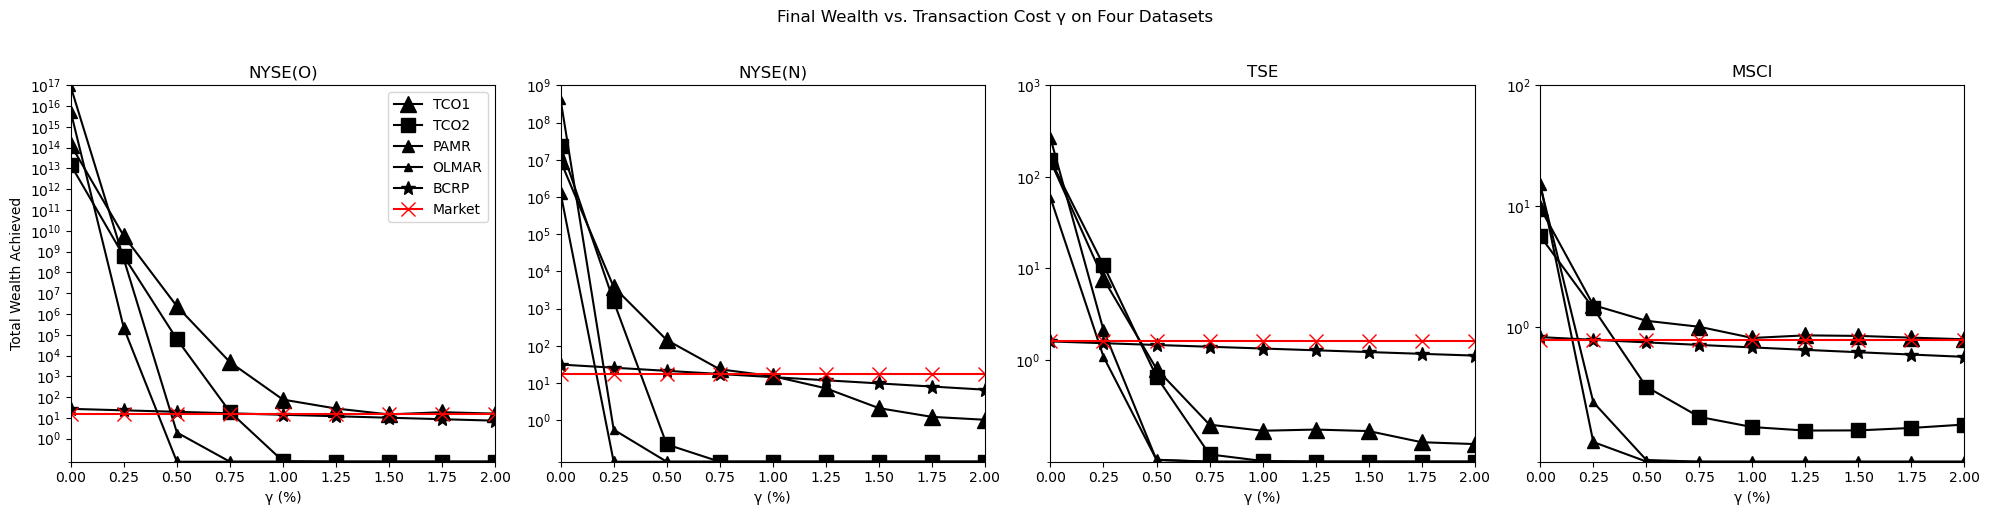

In [99]:
import matplotlib.ticker as ticker


gamma_list = np.linspace(0.0, 0.02, 9)   
strategies = ["TCO1", "TCO2", "PAMR", "OLMAR", "BCRP", "Market"]

style = {
    "TCO1":   {"marker": "^", "markersize": 12, "color": "black"},
    "TCO2":   {"marker": "s", "markersize": 10, "color": "black"},
    "PAMR":   {"marker": "^", "markersize": 8,  "color": "black"},
    "OLMAR":  {"marker": "^", "markersize": 6,  "color": "black"},
    "BCRP":   {"marker": "*", "markersize": 10, "color": "black"},
    "Market": {"marker": "x", "markersize": 10, "color": "red"  }
}

def wealth_bcrp(arr, b, gamma):
    S = 1.0
    T, m = arr.shape
    for t in range(T):
        x = arr[t]
        ret = b @ x
        hat_b = b * x / ret
        w_star = 1.0 if (gamma == 0 or t == T-1) else find_w(hat_b, b, gamma)
        S *= ret * w_star
    return S

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharex=True, sharey=False)

for ax, arr, title in zip(axes, datasets, dataset_names):
    m = arr.shape[1]
    b_eq = np.ones(m) / m
    buy_and_hold = b_eq @ np.prod(arr, axis=0)

    results = {s: [] for s in strategies}
    for γ in gamma_list:
        f1, _    = tco1_with_tc(arr, gamma=γ)
        f2, _, _ = tco2_with_tc(arr, gamma=γ, eta=10.0, w=4)
        fp, _, _ = run_pamr_with_tc(arr, epsilon=0.5, gamma=γ)
        fo, _, _ = run_olmar_with_tc(arr, epsilon=10.0, w=5, gamma=γ)
        fbcrp    = wealth_bcrp(arr, b_eq, γ)
        fmkt     = buy_and_hold

        results["TCO1"].append(f1)
        results["TCO2"].append(f2)
        results["PAMR"].append(fp)
        results["OLMAR"].append(fo)
        results["BCRP"].append(fbcrp)
        results["Market"].append(fmkt)

    gamma_pct = (gamma_list * 100).round(2)
    df = pd.DataFrame(results, index=gamma_pct)
    df.index.name = 'γ (%)'

    for strat in strategies:
        st = style[strat]
        ax.plot(df.index, df[strat],
                marker=st["marker"],
                markersize=st["markersize"],
                color=st["color"],
                linestyle='-',
                label=strat)

    ax.set_title(title)
    ax.set_xlabel('γ (%)')
    if ax is axes[0]:
        ax.set_ylabel('Total Wealth Achieved')

    max_val = df.values.max()
    exp_min = 0
    exp_max = int(np.ceil(np.log10(max_val)))
    major_ticks = [10**e for e in range(exp_min, exp_max+1)]

    ax.set_yscale('symlog', linthresh=10**exp_min)
    ax.yaxis.set_major_locator(ticker.FixedLocator(major_ticks))
    ax.yaxis.set_major_formatter(
        ticker.FuncFormatter(lambda y, _: f"$10^{{{int(np.log10(y))}}}$" if y>0 else "0")
    )
    ax.set_ylim(0, 10**exp_max)
    ax.set_xlim(gamma_pct.min(), gamma_pct.max())

    if ax is axes[0]:
        ax.legend(loc='best')

plt.suptitle('Final Wealth vs. Transaction Cost γ on Four Datasets', y=1.02)
plt.tight_layout()
plt.show()


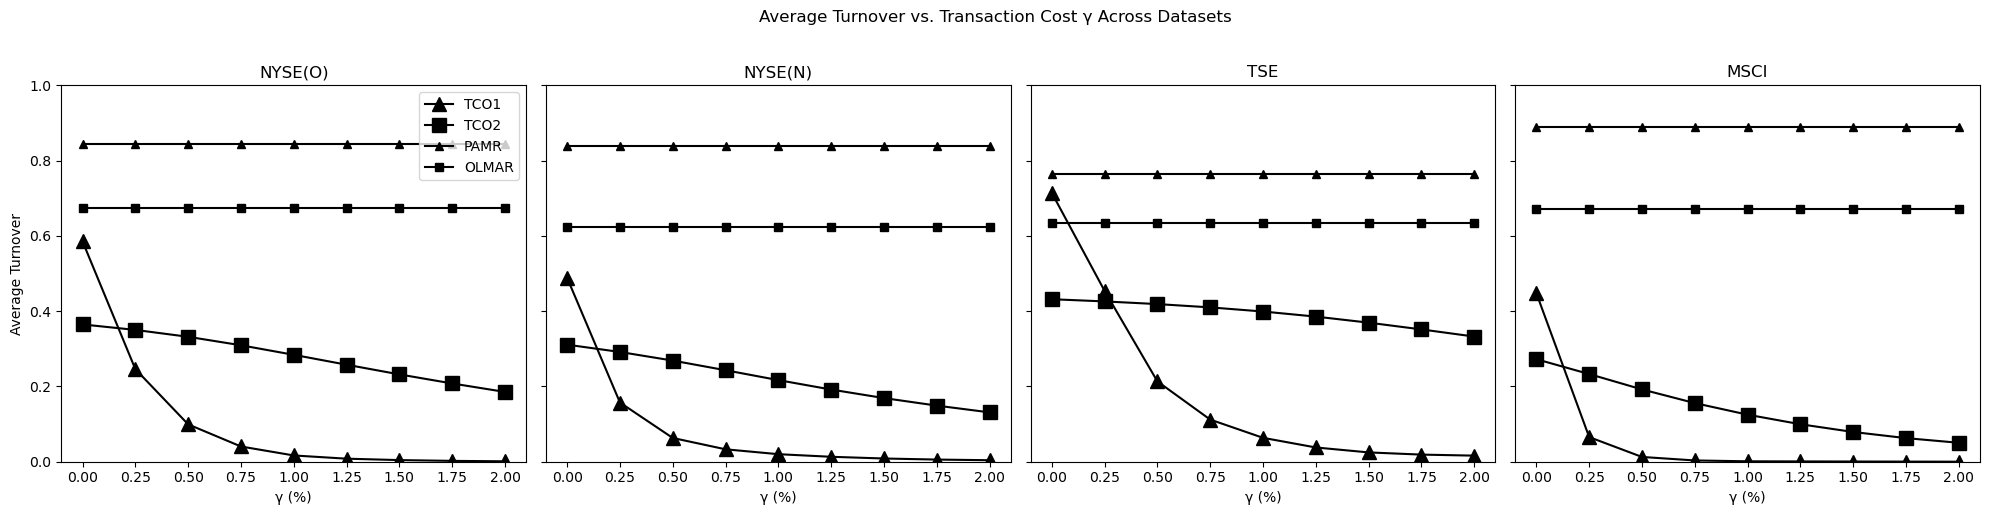

In [132]:
def tco2_with_tc_and_turnover(arr, gamma=0.0, eta=10.0, w=4):

    T, m = arr.shape
    b = np.full(m, 1.0 / m)
    S = 1.0
    wealth_curve = np.empty(T)
    ret_series = np.empty(T)
    turnover_series = np.zeros(T)

    buffer = np.zeros((w-1, m))
    buf_filled = 0

    for t in range(T):
        x_t = arr[t]
        terms = [np.ones(m), 1.0/x_t]
        cum = x_t.copy()
        for i in range(min(buf_filled, w-1)):
            cum *= buffer[i]
            terms.append(1.0/cum)
        if len(terms) < w:
            terms += [np.zeros(m)]*(w-len(terms))
        f2 = sum(terms[:w]) / w

        ret = b @ x_t
        hat_b = b * x_t / ret

        if t < T-1:
            v = f2 / (hat_b @ f2)
            v_bar = v.mean()
            delta0 = eta*(v - v_bar)
            lam = 10.0*gamma
            delta = np.sign(delta0)*np.maximum(np.abs(delta0)-lam, 0.0)
            b_prop = hat_b + delta
            b_cand = project_to_simplex(b_prop)
            w_star = find_w(hat_b, b_cand, gamma)
        else:
            b_cand = hat_b
            w_star = 1.0

        turnover_series[t] = np.abs(hat_b - w_star*b_cand).sum()

        total_ret = ret * w_star
        S *= total_ret
        wealth_curve[t] = S
        ret_series[t] = total_ret

        b = b_cand
        if w>1:
            if buf_filled < w-1:
                buffer[1:buf_filled+1] = buffer[:buf_filled]
                buffer[0] = x_t
                buf_filled += 1
            else:
                buffer[1:] = buffer[:-1]
                buffer[0] = x_t

    n = T-1
    avg_turnover = turnover_series[:n].sum()/(2*n)

    return S, wealth_curve, ret_series, turnover_series, avg_turnover




def tco1_with_tc_and_turnover(arr, gamma=0.0, eta=10.0):

    n_days, m = arr.shape
    b = np.ones(m) / m
    S = 1.0

    wealth_curve    = np.zeros(n_days)
    ret_series      = np.zeros(n_days)
    turnover_series = np.zeros(n_days)

    for t in range(n_days):
        x_t = arr[t]
        ret = b @ x_t
        hat_b = (b * x_t) / ret

        if t < n_days - 1:
            tilde_x = 1.0 / x_t
            v = tilde_x / (hat_b @ tilde_x)
            v_bar = v.mean()
            tilde_b = eta * (v - v_bar)

            lam = 10.0 * gamma
            thresh = lam * eta
            delta = np.sign(tilde_b) * np.maximum(np.abs(tilde_b) - thresh, 0.0)
            b_prop = hat_b + delta
            b_candidate = project_to_simplex(b_prop)

            w = find_w(hat_b, b_candidate, gamma)
        else:
            b_candidate = hat_b
            w = 1.0

        turnover_series[t] = np.abs(hat_b - w * b_candidate).sum()
        total_ret = ret * w

        S *= total_ret
        wealth_curve[t] = S
        ret_series[t]   = total_ret

        b = b_candidate

    n = n_days - 1
    avg_turnover = turnover_series[:n].sum() / (2 * n)

    return S, wealth_curve, ret_series, turnover_series, avg_turnover



def run_olmar_with_tc_and_turnover(X, epsilon=10.0, w=5, gamma=0.0):

    X = np.asarray(X, float)
    n_days, d = X.shape
    
    p = np.ones((n_days+1, d))
    for t in range(1, n_days+1):
        p[t] = p[t-1] * X[t-1]
    
    b = np.ones(d) / d
    S = 1.0
    equity_curve = np.zeros(n_days)
    portfolios = np.zeros((n_days+1, d))
    portfolios[0] = b.copy()
    
    ret_series = np.zeros(n_days)
    turnover_series = np.zeros(n_days)
    
    for t in range(1, n_days+1):
        x_t = X[t-1]
        ret = np.dot(b, x_t)
        hat_b = (b * x_t) / ret
        
        k = min(w, t)
        window = p[t-k+1:t+1]
        p_bar = window.mean(axis=0)
        p_t = p[t]
        with np.errstate(divide='ignore', invalid='ignore'):
            x_pred = np.where(p_t > 0, p_bar / p_t, 1.0)
        
        b_next = olmar_update(epsilon, x_pred, b)
        
        turnover_series[t-1] = np.linalg.norm(hat_b - b_next, 1)
        
        cost_frac = gamma * turnover_series[t-1]
        total_ret = ret * (1 - cost_frac)
        
        S *= total_ret
        equity_curve[t-1] = S
        ret_series[t-1] = total_ret
        portfolios[t] = b_next.copy()
        
        b = b_next
    
    avg_turnover = turnover_series.sum() / (2 * n_days)
    
    return S, equity_curve, portfolios, ret_series, turnover_series, avg_turnover


def run_pamr_with_tc_and_turnover(X, epsilon=0.5, gamma=0.0):

    X = np.asarray(X, dtype=float)
    n_days, d = X.shape
    
    b = np.ones(d) / d
    S = 1.0
    equity_curve = np.zeros(n_days)
    portfolios = np.zeros((n_days+1, d))
    portfolios[0] = b.copy()
    
    ret_series = np.zeros(n_days)
    turnover_series = np.zeros(n_days)
    
    for t in range(n_days):
        x_t = X[t]
        ret = np.dot(b, x_t)
        hat_b = (b * x_t) / ret
        
        b_next = pamr_update(epsilon, x_t, b)
        
        turnover_series[t] = np.linalg.norm(hat_b - b_next, 1)
        
        cost_frac = gamma * turnover_series[t]
        total_ret = ret * (1.0 - cost_frac)
        
        S *= total_ret
        equity_curve[t] = S
        ret_series[t] = total_ret
        portfolios[t+1] = b_next.copy()
        
        b = b_next
    
    avg_turnover = turnover_series.sum() / (2*n_days)
    
    return S, equity_curve, portfolios, ret_series, turnover_series, avg_turnover




gamma_list = np.linspace(0.0, 0.02, 9)  # 0% → 2%
gamma_pct = (gamma_list * 100).round(2)

strategies = ['TCO1', 'TCO2', 'PAMR', 'OLMAR']
strategy_funcs = {
    'TCO1': tco1_with_tc_and_turnover,
    'TCO2': tco2_with_tc_and_turnover,
    'PAMR': run_pamr_with_tc_and_turnover,
    'OLMAR': run_olmar_with_tc_and_turnover
}

style = {
    'TCO1':  {'marker': '^', 'markersize': 10, 'color': 'black'},
    'TCO2':  {'marker': 's', 'markersize': 10, 'color': 'black'},
    'PAMR':  {'marker': '^', 'markersize': 6,  'color': 'black'},
    'OLMAR': {'marker': 's', 'markersize': 6,  'color': 'black'}
}

avg_turnover_data = {name: pd.DataFrame(index=gamma_pct, columns=strategies)
                     for name in dataset_names}

for arr, name in zip(datasets, dataset_names):
    for γ, pct in zip(gamma_list, gamma_pct):
        for strat in strategies:
            func = strategy_funcs[strat]
            *_, avg_turn = func(arr, gamma=γ)
            avg_turnover_data[name].loc[pct, strat] = avg_turn

fig, axes = plt.subplots(1, 4, figsize=(20, 5), sharey=True)

for ax, name in zip(axes, dataset_names):
    df = avg_turnover_data[name].astype(float)
    for strat in strategies:
        st = style[strat]
        ax.plot(df.index, df[strat],
                marker=st['marker'],
                markersize=st['markersize'],
                color=st['color'],
                linestyle='-',
                label=strat)
    ax.set_title(name)
    ax.set_xlabel('γ (%)')
    ax.set_ylim(0, 1)
    if ax is axes[0]:
        ax.set_ylabel('Average Turnover')
        ax.legend(loc='upper right')

plt.suptitle('Average Turnover vs. Transaction Cost γ Across Datasets', y=1.02)
plt.tight_layout()
plt.show()


In [57]:

def tco1(arr, gamma, eta, lam_factor):

    n_days, m = arr.shape
    b = np.ones(m) / m
    S = 1.0
    lam = lam_factor * gamma
    for t in range(n_days):
        x_t = arr[t]
        ret = np.dot(b, x_t)
        S *= ret
        hat_b = (b * x_t) / ret
        if t < n_days - 1:                      
            tilde_x = 1.0 / x_t
            v = tilde_x / np.dot(hat_b, tilde_x)
            tilde_b = eta * (v - v.mean())
            shrink = np.maximum(np.abs(tilde_b) - lam * eta, 0.0)
            b_candidate = project_to_simplex(hat_b + np.sign(tilde_b) * shrink)
            S *= find_w(hat_b, b_candidate, gamma)
            b = b_candidate
    return S


lam_factors = np.logspace(-2, 2, 5)    
eta_values  = np.logspace(-2, 4, 7)    
gamma = 0.0025                         


heat_maps = {}
for dataset_name, dataset in zip(dataset_names,datasets):
    H = np.empty((len(lam_factors), len(eta_values)))
    for i, lam_fac in tqdm(list(enumerate(lam_factors)),
                           desc=f"Processing {dataset_name}", leave=False):
        for j, eta in enumerate(eta_values):
            H[i, j] = tco1(dataset, gamma, eta, lam_fac)
    heat_maps[dataset_name] = H
def tco2_with_tc(arr, *, gamma=0.0, eta=10.0, lam_factor=10.0, w=4):
    
    T, m = arr.shape
    b = np.full(m, 1.0 / m)
    S = 1.0
    wealth_curve = np.empty(T)

    buffer = np.zeros((w - 1, m))
    buf_filled = 0

    for t in range(T):
        x_t = arr[t]

        terms = [np.ones(m), 1.0 / x_t]
        cum_prod = x_t.copy()
        for i in range(min(buf_filled, w - 1)):
            cum_prod *= buffer[i]
            terms.append(1.0 / cum_prod)
        if len(terms) < w:
            terms += [np.zeros(m)] * (w - len(terms))
        f2 = np.sum(terms[:w], axis=0) / w

        ret = b @ x_t
        S *= ret
        wealth_curve[t] = S
        hat_b = b * x_t / ret

        if t == T - 1:                 
            break

        v = f2 / (hat_b @ f2)
        delta0 = eta * (v - v.mean())
        lam = lam_factor * gamma       
        delta = np.sign(delta0) * np.maximum(np.abs(delta0) - lam, 0.0)

        b_prop = hat_b + delta
        b_cand = project_to_simplex(b_prop)
        w_star = find_w(hat_b, b_cand, gamma)
        S *= w_star
        b = b_cand

        if w > 1:
            if buf_filled < w - 1:
                buffer[1:buf_filled + 1] = buffer[:buf_filled]
                buffer[0] = x_t
                buf_filled += 1
            else:
                buffer[1:] = buffer[:-1]
                buffer[0] = x_t

    return S, wealth_curve



lam_factors = np.logspace(-2, 2, 5)
eta_values  = np.logspace(-2, 4, 7)
gamma = 0.0025

heat_maps_tco2 = {}

for dataset_name, dataset in zip(dataset_names, datasets):
    H = np.empty((len(lam_factors), len(eta_values)))
    for i, lam_fac in tqdm(enumerate(lam_factors),
                           desc=f"Processing {dataset_name} (TCO2)",
                           leave=False):
        for j, eta in enumerate(eta_values):
            final_S, _ = tco2_with_tc(
                dataset,
                gamma=gamma,
                eta=eta,
                lam_factor=lam_fac,   
                w=4
            )
            H[i, j] = final_S
    heat_maps_tco2[dataset_name] = H


Processing NYSE(O):   0%|          | 0/5 [00:00<?, ?it/s]

Processing NYSE(N):   0%|          | 0/5 [00:00<?, ?it/s]

Processing TSE:   0%|          | 0/5 [00:00<?, ?it/s]

Processing MSCI:   0%|          | 0/5 [00:00<?, ?it/s]

Processing NYSE(O) (TCO2): 0it [00:00, ?it/s]

Processing NYSE(N) (TCO2): 0it [00:00, ?it/s]

Processing TSE (TCO2): 0it [00:00, ?it/s]

Processing MSCI (TCO2): 0it [00:00, ?it/s]

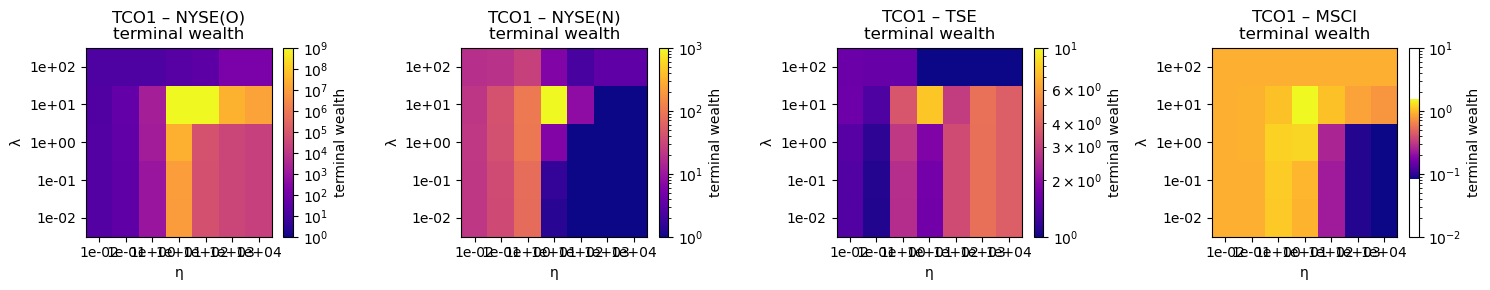

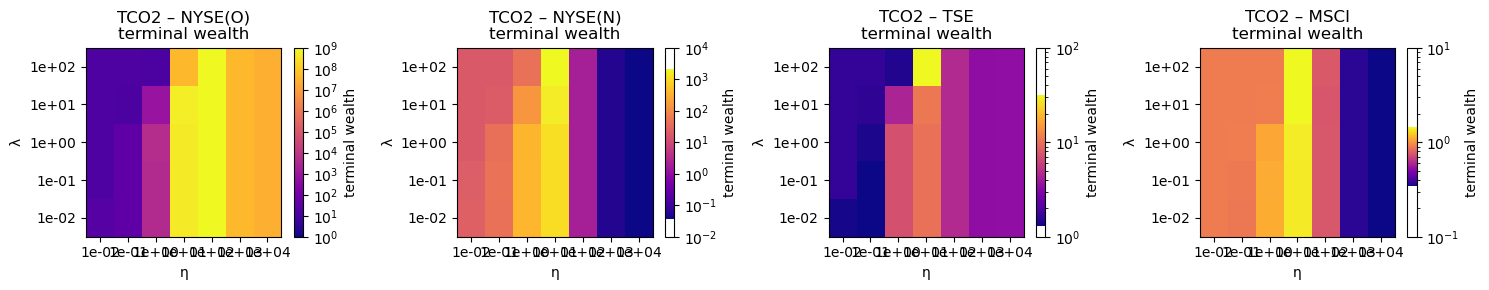

In [60]:
log_limits = {
    "NYSE(O)": dict(vmin=1e0,  vmax=1e9),   
    "NYSE(N)": dict(vmin=1e0,  vmax=1e3),   
    "TSE"    : dict(vmin=1e0,  vmax=1e1),   
    "MSCI"   : dict(vmin=1e0,  vmax=3e0),   
}

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
axes = axes.flatten()

for ax, name in zip(axes, dataset_names):
    H = heat_maps[name]
    if name == "MSCI":
        vmin = max(H.min(), 1e-6)   
        vmax = H.max()
    else:
        vmin = log_limits[name]["vmin"]
        vmax = log_limits[name]["vmax"]


    im = ax.imshow(
        H,
        origin="lower",
        aspect="auto",
        cmap="plasma",
        norm=LogNorm(vmin=vmin, vmax=vmax)   
    )

    ax.set_xticks(np.arange(len(eta_values)))
    ax.set_xticklabels([f"{v:.0e}" for v in eta_values])
    ax.set_yticks(np.arange(len(lam_factors)))
    ax.set_yticklabels([f"{v:.0e}" for v in lam_factors])
    ax.set_xlabel("η")
    ax.set_ylabel("λ")
    ax.set_title(f"TCO1 – {name}\nterminal wealth")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("terminal wealth")
    ticks = np.logspace(np.floor(np.log10(vmin)),
                        np.ceil(np.log10(vmax)),
                        num=int(np.ceil(np.log10(vmax)) -
                                np.floor(np.log10(vmin)) + 1))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(t))}}}$" for t in ticks])

plt.tight_layout()
plt.show()

log_limits = {
    "NYSE(O)": dict(vmin=1e0,  vmax=1e9),   
    "NYSE(N)": dict(vmin=1e0,  vmax=1e3),  
    "TSE"    : dict(vmin=1e0,  vmax=1e1),   
    "MSCI"   : dict(vmin=1e0,  vmax=3e0),   
}

fig, axes = plt.subplots(1, 4, figsize=(15, 3))
axes = axes.flatten()

for ax, name in zip(axes, dataset_names):
    H = heat_maps_tco2[name]
    if name == "MSCI" or name == "TSE" or name == "NYSE(N)":
        vmin = max(H.min(), 1e-6)  
        vmax = H.max()
    else:
        vmin = log_limits[name]["vmin"]
        vmax = log_limits[name]["vmax"]

    im = ax.imshow(
        H,
        origin="lower",
        aspect="auto",
        cmap="plasma",
        norm=LogNorm(vmin=vmin, vmax=vmax)   # << log-scaled colour map
    )

    ax.set_xticks(np.arange(len(eta_values)))
    ax.set_xticklabels([f"{v:.0e}" for v in eta_values])
    ax.set_yticks(np.arange(len(lam_factors)))
    ax.set_yticklabels([f"{v:.0e}" for v in lam_factors])
    ax.set_xlabel("η")
    ax.set_ylabel("λ")
    ax.set_title(f"TCO2 – {name}\nterminal wealth")

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label("terminal wealth")
    ticks = np.logspace(np.floor(np.log10(vmin)),
                        np.ceil(np.log10(vmax)),
                        num=int(np.ceil(np.log10(vmax)) -
                                np.floor(np.log10(vmin)) + 1))
    cbar.set_ticks(ticks)
    cbar.set_ticklabels([f"$10^{{{int(np.log10(t))}}}$" for t in ticks])

plt.tight_layout()
plt.show()


### Parameter-sensitivity highlights (Figure 3)

* **Mid-range sweet spot**  
  *Brightest areas of each heat-map fall in the middle of both parameter axes (η, λ), showing a wide zone where the strategy performs well.*

* **Effect of increasing η (λ fixed)**  
  Wealth **rises**, peaks at an intermediate η, then **declines** as η grows further.

* **Effect of varying λ (η fixed)**  
  * **Small η:** wealth is nearly flat across λ (upper & lower rows look similar).  
  * **Mid-range η:** wealth rises, peaks at a middle λ, then falls.  
  * **Large η:** larger λ values hurt performance (lower rows dark).

* **Rule-of-thumb setting**  
  Authors use **η = λ = 10** throughout; this pair is simple and delivers solid—though not strictly optimal—results across datasets.
